# Import packages and set default plotting parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii, votable
from astropy.table import Table, vstack, hstack
import os, sys
from scipy.interpolate import interp1d
import importlib
import emcee
from multiprocessing import Pool
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic # Low-level frames
import astropy.units as u
import WD_HR
import WD_models
#!scp 'scheng@dslogin01.pha.jhu.edu:~/Gaia/WD_MCMC_func.py' '.' 
#!scp 'scheng@dslogin01.pha.jhu.edu:~/Gaia/WD_vel_age_MCMC_Mar2.py' '.' 
import WD_MCMC_func
importlib.reload(WD_MCMC_func)
from WD_MCMC_func import *
import corner



tick_size = 17#15
label_size = 17#17
title_size = 17#17
plt.rc('ytick', labelsize=tick_size) 
plt.rc('xtick', labelsize=tick_size) 
plt.rc('font', family='Helvetica', size=label_size) 
plt.rc('axes', labelsize=label_size)
plt.rc('legend', fontsize=label_size)
plt.rc('figure', titlesize=title_size)

/Users/scheng/Gaia/WD_models.py:190: RuntimeWarning: divide by zero encountered in power
  (IFMR(int(mass)/100))**(t_index)*10**10)
/Users/scheng/Gaia/WD_models.py:128: RuntimeWarning: invalid value encountered in less
  selected = ~np.isnan(bp_rp_fontaine+G_fontaine+age+para)*(G_fontaine<16)*(G_fontaine>8)
/Users/scheng/Gaia/WD_models.py:128: RuntimeWarning: invalid value encountered in greater
  selected = ~np.isnan(bp_rp_fontaine+G_fontaine+age+para)*(G_fontaine<16)*(G_fontaine>8)
/Users/scheng/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:634: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/Users/scheng/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:635: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/Users/scheng/Gaia/WD_models.py:22: RuntimeWarning: invalid value encountered in greater
  return (mass_ini>0.8)*mass_ini**(-2.3)
/Users/scheng/Gaia/WD_model

WD_MCMC_func.py                               100%   34KB 910.7KB/s   00:00    
WD_vel_age_MCMC_Mar2.py                       100%   24KB 420.2KB/s   00:00    


# Load WD_warwick_smaller

In [2]:
WD_warwick_smaller = np.load('WD_warwick_smaller.npy')[0]['WD_warwick_smaller']
_, WD = WD_MCMC_func.select_WD(WD_warwick_smaller,1.7,0.15,2,22,5,250)

94014


In [3]:
def plot_age_mass(distance1=0, distance2=250, spec_type='DA_thick', model='ONe'):
    selected = (1/WD['parallax']*1000>distance1)*(1/WD['parallax']*1000<distance2)\
                        #*(WD['age_'+spec_type+'_'+model]<3.5)*(WD['age_'+spec_type+'_'+model]>2)# * (WD['mass_'+spec_type+'_'+model]>1.10)
    selected_Q = (1/WD_Q['parallax']*1000>distance1)*(1/WD_Q['parallax']*1000<distance2)# * (WD_Q['mass_'+spec_type+'_'+model]>1.10)
    pml,pmb,factor = prep_get_v(WD)
    pml_Q, pmb_Q, factor_Q = prep_get_v(WD_Q)
    v_drift = (((WD['age_'+spec_type+'_'+model]+0.1)/10.1)**0.2*40)**2/80
    v_drift_Q = (((WD_Q['age_'+spec_type+'_'+model]+0.1)/10.1)**0.2*40)**2/80
    vL, vB = np.array(get_v_delayed_3D(WD['age_'+spec_type+'_'+model], WD['l'], WD['b'], pml, pmb, factor, v_drift,9,7,7))
    vL_Q, vB_Q = np.array(get_v_delayed_3D(WD_Q['age_'+spec_type+'_'+model], WD_Q['l'], WD_Q['b'], pml_Q, pmb_Q, factor_Q, v_drift_Q,\
                                       9,7,7))
    
    plt.figure(figsize=(15,4),dpi=200)
    ax=plt.subplot(111)
    plt.scatter(WD['age_'+spec_type+'_'+model][selected], WD['mass_'+spec_type+'_'+model][selected], c=(vL**2+vB**2)[selected]**0.5, \
                s=1, vmin=0, vmax=60, cmap='rainbow')
    plt.scatter(WD_Q['age_'+spec_type+'_'+model][selected_Q], WD_Q['mass_'+spec_type+'_'+model][selected_Q],c=(vL_Q**2+vB_Q**2)[selected_Q]**0.5, \
                s=10, vmin=0, vmax=60, cmap='rainbow',marker='^')
    #plt.plot((1.22-np.array([1.075,1.22]))/0.2+0.6, np.array([1.075,1.22]) )
    plt.plot((1.22-np.array([1.075,1.22]))/0.2+0.6-0.2, np.array([1.075,1.22]),'k--' )
    plt.plot((1.22-np.array([1.075,1.22]))/0.14+0.15+0.6, np.array([1.075,1.22]),'k--' )


    plt.xlabel('cooling age [Gyr]')
    plt.yticks([1.1,1.15,1.2])
    plt.ylabel('mass [$M_{\odot}$]')
    #plt.grid()
    plt.colorbar()
    plt.text(1.04,0.5,'transverse velocity [km/s]',rotation=90,horizontalalignment='center',verticalalignment='center',
             transform=ax.transAxes, fontsize=label_size)
    plt.show()
    
    plt.figure(figsize=(18,5))
    #plt.subplot(111, projection='mollweide')# • here 111 means “subplot 1 of a 1x1 grid of plots”
    plt.scatter(WD['l'][selected], WD['b'][selected], c=vB[selected], \
                s=10, vmin=-100, vmax=100, cmap='rainbow')
    #plt.scatter(WD_Q['l'][selected_Q], WD_Q['b'][selected_Q],c=vB_Q[selected_Q], \
    #            s=10, vmin=-70, vmax=70, cmap='rainbow')
    plt.show()
    
    plt.figure(figsize=(9,9))
    plt.scatter(WD['bp_rp'][selected], WD['G'][selected], c=(vL**2+vB**2)[selected]**0.5, \
                s=1, vmin=-10, vmax=100,cmap='cool')
    plt.scatter(WD_Q['bp_rp'][selected_Q], WD_Q['G'][selected_Q], c=(vL_Q**2+vB_Q**2)[selected_Q]**0.5, \
                s=5, vmin=-10, vmax=100,cmap='cool')
    #plt.plot(age_Q, mass_Q, '.')
    plt.ylim(16,11)
    plt.show()
    
    
    plt.hist(vstack((WD[selected],WD_Q[selected_Q]))['mass_'+spec_type+'_'+model],15)
    plt.show()

In [4]:
mass_min = 1.08#1.07#1.09
mass_max = 1.23#1.22#1.27
distance1 = 0
distance2 = 250
spec_type = 'DA_thick'
model = 'ONe'
WD_model = eval('WD_models.'+spec_type+'_'+model)
age_lim = 3.5
WD_warwick_smaller['mass'] = WD_warwick_smaller['mass_'+spec_type+'_'+model]
WD_warwick_smaller['age'] = WD_warwick_smaller['age_'+spec_type+'_'+model]
Q_branch = np.array((WD_warwick_smaller['mass']>mass_min)*(WD_warwick_smaller['mass']<mass_max)*\
         (1/WD_warwick_smaller['parallax']*1000>distance1)*(1/WD_warwick_smaller['parallax']*1000<distance2)*\
        (WD_HR.func_select(WD_warwick_smaller['bp_rp'],WD_warwick_smaller['G'],13.20,1.2,0.20,-0.40,0.10)) )
WD = WD_warwick_smaller[np.array((WD_warwick_smaller['mass']>mass_min)*(WD_warwick_smaller['mass']<mass_max)*\
        (1/WD_warwick_smaller['parallax']*1000>distance1)*(1/WD_warwick_smaller['parallax']*1000<distance2)\
         * ~Q_branch )]
WD_Q = WD_warwick_smaller[Q_branch]

print('length of WD: ',len(WD), 'length of WD_Q: ',len(WD_Q))


# prepare to get v
pml,pmb,factor = WD_MCMC_func.prep_get_v(WD)
pml_Q, pmb_Q, factor_Q = WD_MCMC_func.prep_get_v(WD_Q)
v_drift = (((WD['age']+0.1)/10.1)**0.2*40)**2/stromberg_k
v_drift_Q = (((WD_Q['age']+0.1)/10.1)**0.2*40)**2/stromberg_k
vL, vB = np.array(WD_MCMC_func.get_v_delayed_3D(WD['age'], WD['l'], WD['b'], pml, pmb, factor, v_drift,11,7.5,7))
vL_Q, vB_Q = np.array(WD_MCMC_func.get_v_delayed_3D(WD_Q['age'], WD_Q['l'], WD_Q['b'], pml_Q, pmb_Q, factor_Q, v_drift_Q,\
                                       11,7.5,7))

selection = np.array(((WD['age'])<age_lim)*((WD['age'])>0.1)*(np.abs(vL<200))*(np.abs(vB<200)))
mass = np.array(WD['mass'][selection])
age = np.array(WD['age'][selection])
l = np.array(WD['l'][selection])
b = np.array(WD['b'][selection])
vL = vL[selection]
vB = vB[selection]
pml = pml[selection]
pmb = pmb[selection]
factor = factor[selection]

selection_Q = np.array(((WD_Q['age'])<age_lim)*((WD_Q['age'])>0.1)*(np.abs(vL_Q<200))*(np.abs(vB_Q<200)))
mass_Q = np.array(WD_Q['mass'][selection_Q])
age_Q = np.array(WD_Q['age'][selection_Q])
l_Q = np.array(WD_Q['l'][selection_Q])
b_Q = np.array(WD_Q['b'][selection_Q])
vL_Q = vL_Q[selection_Q]
vB_Q = vB_Q[selection_Q]
pml_Q = pml_Q[selection_Q]
pmb_Q = pmb_Q[selection_Q]
factor_Q = factor_Q[selection_Q]

/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


length of WD:  1437 length of WD_Q:  726


/Users/scheng/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


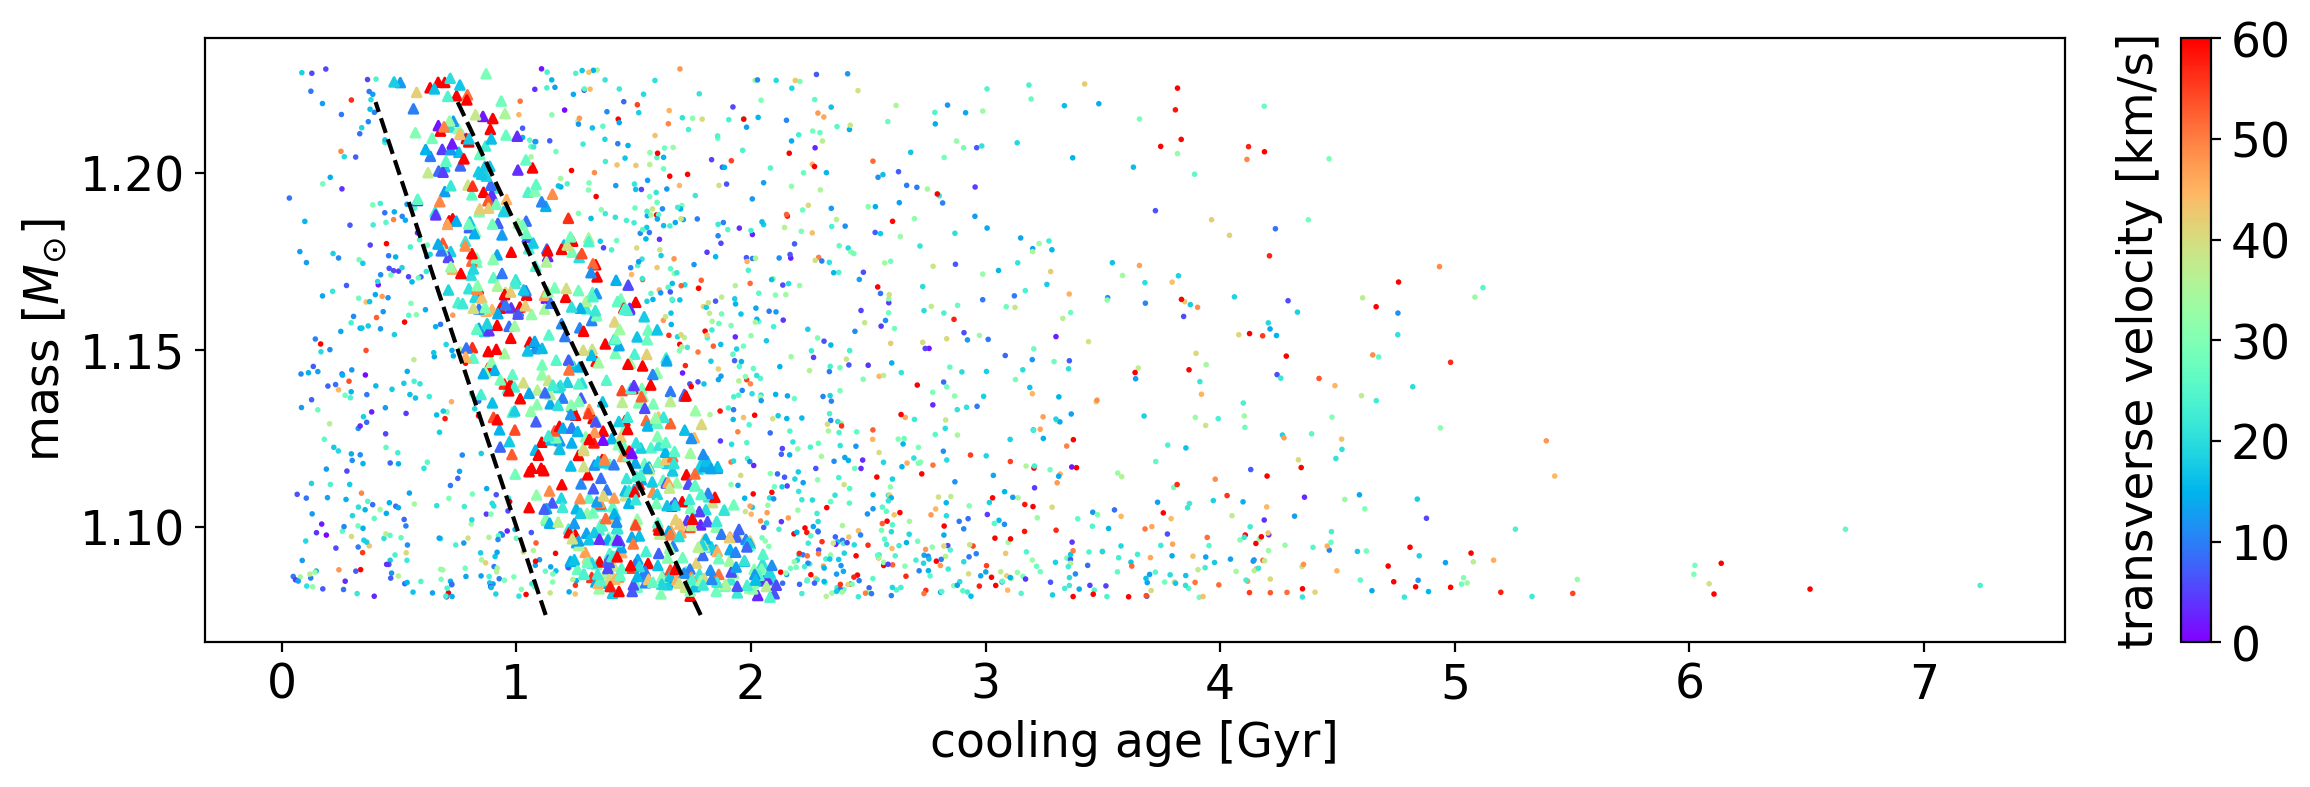

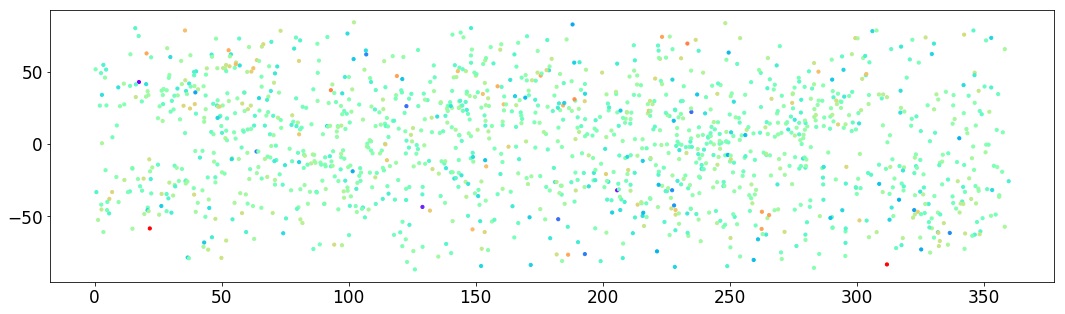

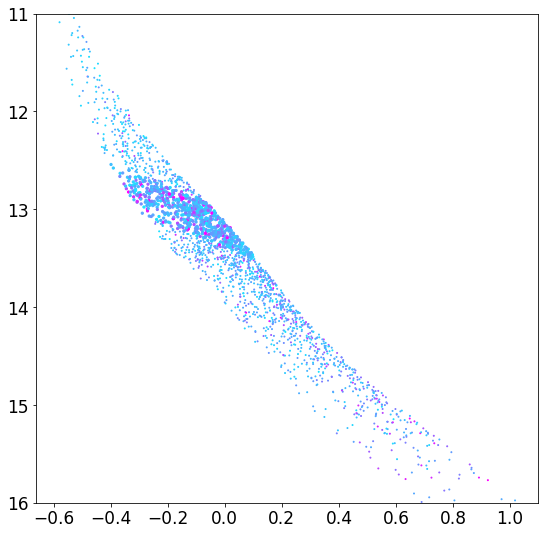

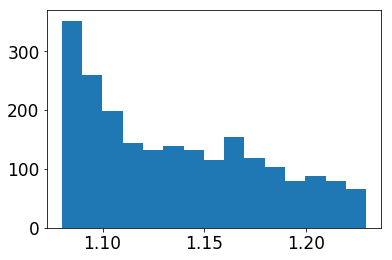

In [5]:
plot_age_mass()

In [32]:
label = [1,11,15,27,28,30,33]
WD_Q['White_dwarf_name','phot_bp_mean_mag','age','vL','vB'][label].show_in_notebook()

KeyError: 'vL'

# Check MCMC result

In [6]:
distance2 = 250
mass_min=1.08
delay_lim = 15

In [7]:
distance2,spec_type,model,mass_min,age_lim

(250, 'DA_thick', 'ONe', 1.08, 3.5)

In [8]:
#!scp 'scheng@dslogin01.pha.jhu.edu:/home/scheng/Gaia/WD_MCMC_func.py' '.'
importlib.reload(WD_MCMC_func)

<module 'WD_MCMC_func' from '/Users/scheng/Gaia/WD_MCMC_func.py'>

In [170]:
#!scp 'scheng@dslogin01.pha.jhu.edu:/datascope/menard/group/scheng/Gaia/WD_vel_age_MCMC_Feb12/MCMC_power_-0.7_0.5_1.08_250_3.5_DA_thick_ONe_11_T6_FFF3Qisnotmerger.npy' '.' 

MCMC_power_-0.7_0.5_1.08_250_3.5_DA_thick_ONe 100%   26MB   1.5MB/s   00:17    


In [37]:
#data = np.load('/datascope/menard/group/scheng/Gaia/WD_vel_age_MCMC_Feb12/\
#MCMC_power_2018_0_1.075_250_3.5_DA_thick_ONe_11_T7_FFF0Qisnotmerger.npy')[0]
#data = np.load('/datascope/menard/group/scheng/Gaia/WD_vel_age_MCMC_Feb12/\
#MCMC_power_-0.7_0.5_1.08_250_3.5_DA_thick_ONe_11_T7_FFF1Qisnotmerger.npy')[0]

#data = np.load('MCMC_power_-0.7_0.5_1.08_250_3.5_DA_thick_ONe_11_T6_FFF3Qisnotmerger.npy')[0] # this set age_thick>6
data = np.load('MCMC_power_-0.7_0.5_1.08_250_3.5_DA_thick_ONe_11_T7_FFF2.npy')[0] # this is the paper version
WD_MCMC_func.age_T = 7

from WD_MCMC_func import *
para_v = data['para_v'][-50000:,:]
para_Q = data['para_Q'][-50000:,:]#[selected]
len(para_Q)

50000

In [38]:
data['data_length'], data['para_input']

([556, 510], array([  3.71069974e-01,   2.53078693e+01,   6.51017297e+01,
          6.69602113e-01,   1.17434956e+01,   6.77925565e-01,
          6.83125927e+00,   4.27446248e+00,   3.20647871e+01,
          5.76200299e-01,   1.04027290e+01,   7.18373637e+00,
          6.59334853e+00,   6.56969917e-02,   1.06516280e+01,
          4.58892627e-03,  -8.89771342e-01,   8.05031042e+01,
          1.29325023e-01,   7.88869925e+00]))

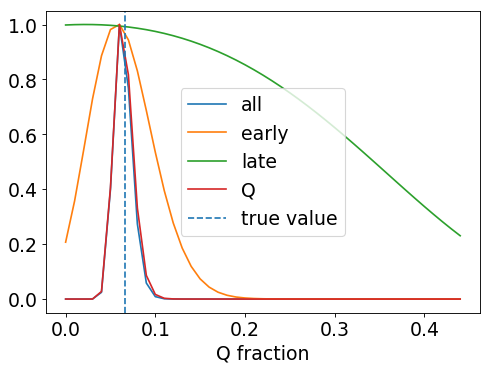

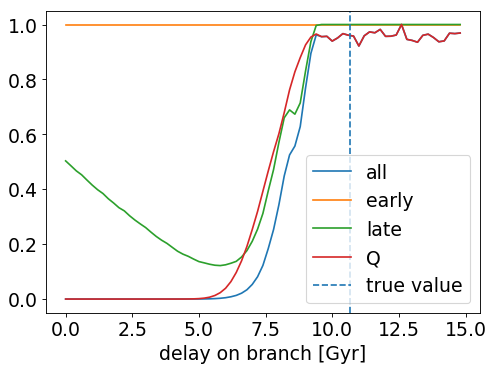

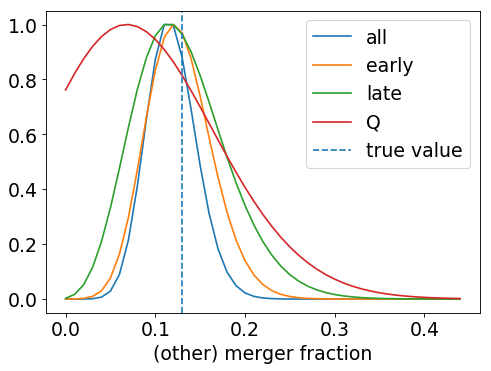

In [39]:
plt.rc('figure',figsize=(7,5),dpi=80)
label = ['all','early','late','Q']
for i in range(0,4):
    plt.plot(np.arange(0,0.45,0.01),np.exp(data['Qfraction'][i]-data['Qfraction'][i].max()),label=label[i])
#plt.title('Q fraction')
plt.xlabel('Q fraction')
plt.axvline(data['para_input'][Nv+0],label='true value',ls='--')
plt.legend()
plt.show()

for i in range(0,4):
    plt.plot(np.arange(0,15,0.2),np.exp(data['delay_test'][i]-data['delay_test'][i].max()),label=label[i])
#plt.title('delay')
plt.axvline(data['para_input'][Nv+1],label='true value',ls='--')
plt.xlabel('delay on branch [Gyr]')
plt.legend()
plt.show()

for i in range(0,4):
    plt.plot(np.arange(0,0.45,0.01),np.exp(data['mfraction'][i]-data['mfraction'][i].max()),label=label[i])
#plt.title('merger fraction')
plt.axvline(data['para_input'][Nv+5],label='true value',ls='--')
plt.xlabel('(other) merger fraction')
plt.legend()
plt.show()

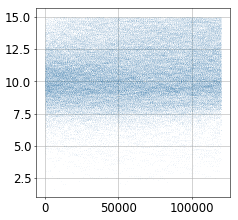

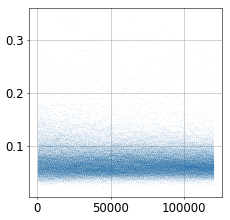

In [40]:
para_v_all = data['para_v'][-0000:,:]
#para_z = data['para_z']
para_Q_all = data['para_Q'][-0000:,:]
plt.figure(figsize=(5,5),dpi=50)
plt.plot(para_Q_all[:,1],'.',ms=1,alpha=0.05) # t_delay
#plt.ylim(10,11)
plt.grid()
plt.show()
plt.figure(figsize=(5,5),dpi=50)
plt.plot(para_Q_all[:,0],'.',ms=1,alpha=0.05) # f_Q
#plt.ylim(8,9)
plt.grid()
plt.show()

In [41]:
N04U = np.array([[1.045,24.210],
[1.430,24.363],
[1.743,26.001],
[1.968,27.333],
[2.160,26.972],
[2.362,29.846],
[2.661,28.013],
[3.779,33.166],
[6.421,39.300],
[10.631,49.022]])

N04V = np.array([[1.046,13.814],
[1.430,15.268],
[1.743,16.414],
[1.967,16.108],
[2.157,15.343],
[2.360,16.448],
[2.662,17.173],
[3.781,21.586],
[6.415,24.297],
[10.634,33.453]])

N04W = np.array([[1.046,10.791],
[1.430,11.642],
[1.743,11.073],
[1.969,11.983],
[2.153,11.827],
[2.359,13.448],
[2.661,13.701],
[3.779,17.236],
[6.410,21.588],
[10.645,27.046]])

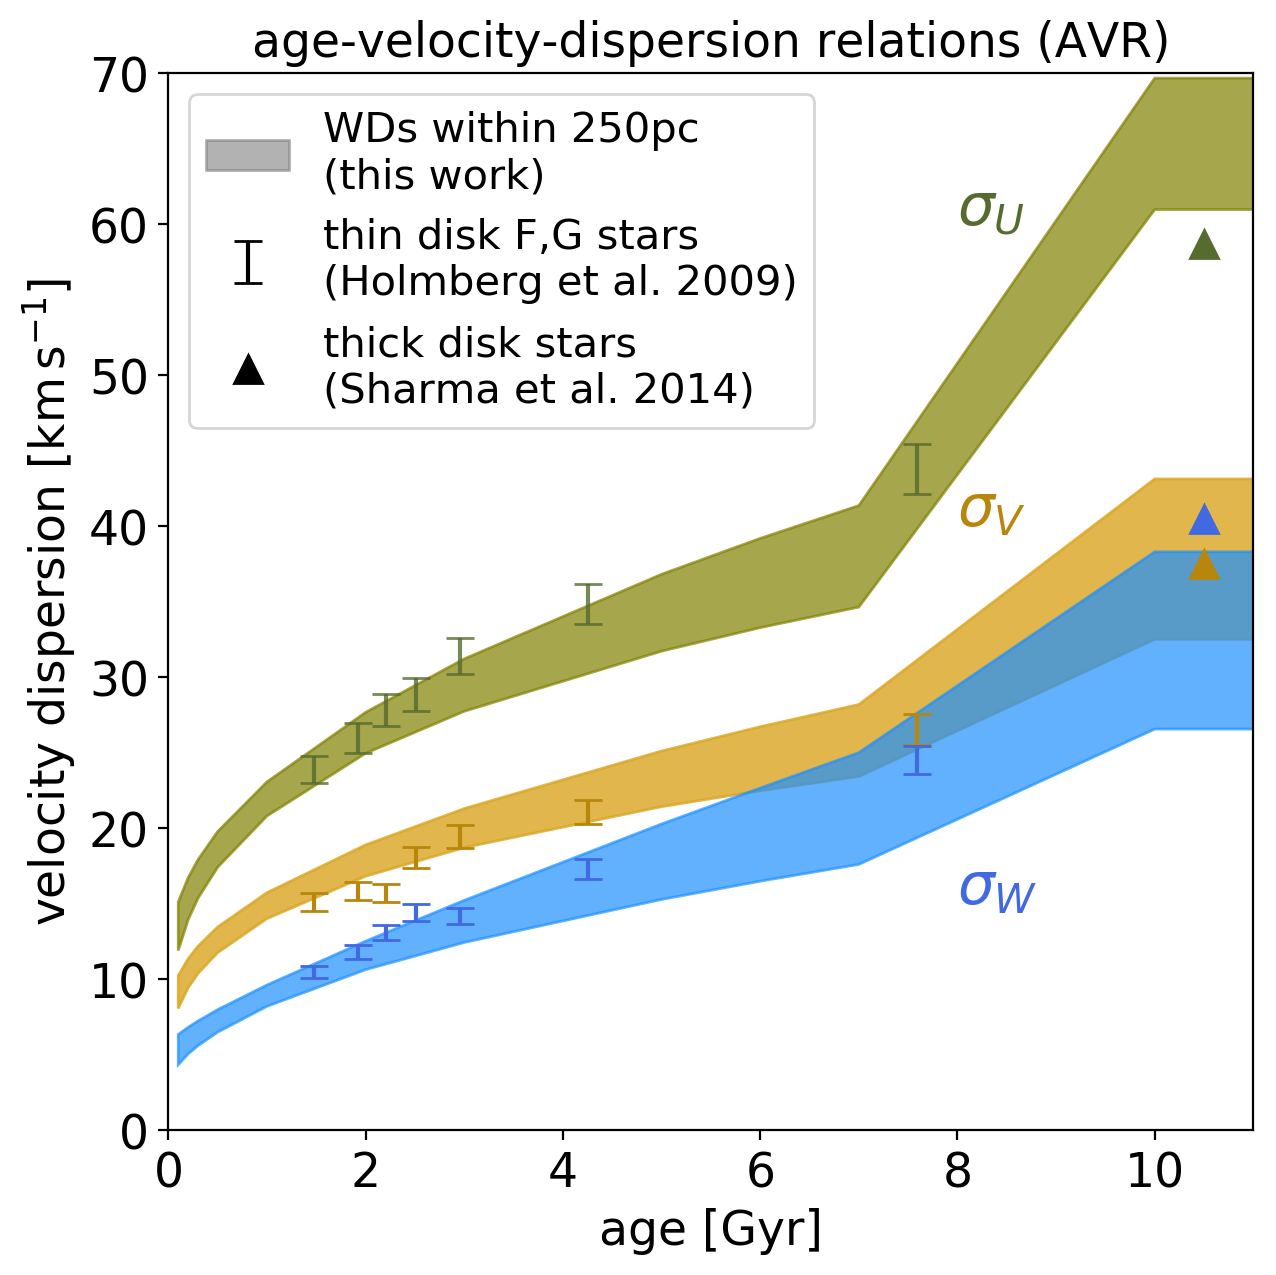

In [194]:
age_list = np.array([0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5,6,7,10,11])
plt.figure(figsize=(7,7),dpi=200)
H09 = True

tick_size = 17#15
label_size = 17#17
title_size = 17#17
plt.rc('ytick', labelsize=tick_size) 
plt.rc('xtick', labelsize=tick_size) 
plt.rc('font', family='Helvetica', size=label_size) 
plt.rc('axes', labelsize=label_size)
plt.rc('legend', fontsize=label_size)
plt.rc('figure', titlesize=title_size)

para_for_loop = [[para_v[:,0],para_v[:,1],para_v[:,2],para_v[:,6]],
                 [para_v[:,0],para_v[:,1]*para_v[:,5],para_v[:,2]*para_v[:,9],para_v[:,6]*para_v[:,5]],
                 [para_v[:,3],para_v[:,4],para_v[:,8],para_v[:,7]],]
color = ['olive','goldenrod','dodgerblue']
alpha = [0.7,0.8,0.7]
for i in range(3):
    y1 = np.percentile(WD_MCMC_func.velocity_scatter_3D(age_list.reshape(-1,1),
                                          para_for_loop[i][0].reshape(1,-1),
                                          para_for_loop[i][1].reshape(1,-1),
                                          para_for_loop[i][2].reshape(1,-1),
                                          para_for_loop[i][3].reshape(1,-1)),16,axis=1)
    y2 = np.percentile(WD_MCMC_func.velocity_scatter_3D(age_list.reshape(-1,1),
                                          para_for_loop[i][0].reshape(1,-1),
                                          para_for_loop[i][1].reshape(1,-1),
                                          para_for_loop[i][2].reshape(1,-1),
                                          para_for_loop[i][3].reshape(1,-1)),84,axis=1)
    plt.fill(np.concatenate((age_list,age_list[::-1])),np.concatenate((y1,y2[::-1])),color=color[i],alpha=alpha[i],
            )

plt.text(8,60,'$\\sigma_U$',fontsize=21,color='darkolivegreen')
plt.text(8,40,'$\\sigma_V$',fontsize=21,color='darkgoldenrod')
plt.text(8,15,'$\\sigma_W$',fontsize=21,color='royalblue')

# plt.plot(age_list,((age_list+0.1)/10.1)**0.2*40) #(Sharma et al)
# plt.plot(age_list,((age_list+0.1)/10.1)**0.37*24) #(Sharma et al)
# plt.plot(age_list, 66*((0.5+age_list)/(0.5+12))**0.5) #(Wegg % Phinney)
# plt.plot(age_list, 62*((0.32+age_list)/(0.32+10))**0.5) #(Wegg % Phinney)


plt.plot([10.5],[58.7],marker='^',ms=10,c='darkolivegreen')
plt.plot([10.5],[37.5],marker='^',ms=10,c='darkgoldenrod')
plt.plot([10.5],[40.5],marker='^',ms=10,c='royalblue')

if H09==True:
    H09U = np.loadtxt('H09/U.txt')
    H09V = np.loadtxt('H09/V.txt')
    H09W = np.loadtxt('H09/W.txt')
    #plt.errorbar(H09U[:,0],H09U[:,1],H09U[:,1]*0.076,ls='',c='darkolivegreen',alpha=0.8,capsize=5)
    #plt.errorbar(H09V[:,0],H09V[:,1],H09V[:,1]*0.076,ls='',c='darkgoldenrod',alpha=1,capsize=5)
    #plt.errorbar(H09W[:,0],H09W[:,1],H09W[:,1]*0.076,ls='',c='royalblue',alpha=1,capsize=5)
    AVR_T = (H09U[:-3,0]+H09U[1:-2,0]+H09U[2:-1,0]+H09U[3:,0])[::4]/4
    AVR_U = (H09U[:-3,1]+H09U[1:-2,1]+H09U[2:-1,1]+H09U[3:,1])[::4]/4
    AVR_V = (H09V[:-3,1]+H09V[1:-2,1]+H09V[2:-1,1]+H09V[3:,1])[::4]/4
    AVR_W = (H09W[:-3,1]+H09W[1:-2,1]+H09W[2:-1,1]+H09W[3:,1])[::4]/4    
    plt.errorbar(AVR_T,AVR_U,AVR_U*0.076/2,ls='',c='darkolivegreen',alpha=0.8,capsize=5)
    plt.errorbar(AVR_T,AVR_V,AVR_V*0.076/2,ls='',c='darkgoldenrod',alpha=1,capsize=5)
    plt.errorbar(AVR_T,AVR_W,AVR_W*0.076/2,ls='',c='royalblue',alpha=1,capsize=5)
else:
    plt.errorbar(N04U[:,0],N04U[:,1],N04U[:,1]*0.061,ls='',c='darkolivegreen',alpha=0.8,capsize=5)
    plt.errorbar(N04V[:,0],N04V[:,1],N04V[:,1]*0.061,ls='',c='darkgoldenrod',alpha=1,capsize=5)
    plt.errorbar(N04W[:,0],N04W[:,1],N04W[:,1]*0.061,ls='',c='royalblue',alpha=1,capsize=5)


import matplotlib.patches as mpatches
our1=mpatches.Patch(color='grey',alpha=0.6,
         label='WDs within 250pc\n(this work)')
rf1=plt.errorbar(-1,-1,1,ls='',c='k',capsize=5,label='thin disk F,G stars\n(Holmberg et al. 2009)')
rf2,=plt.plot(-1,-1,ls='',c='k',marker='^',ms=10,label='thick disk stars\n(Sharma et al. 2014)',zorder=10)


plt.legend(handles=[our1, rf1, rf2],
           loc=2, fontsize=15)
#plt.grid()
plt.title("age-velocity-dispersion relations (AVR)",fontsize=17)
plt.ylim(0,70)
plt.xlim(0,11)
plt.ylabel('velocity dispersion $[\\rm km\,s^{-1}]$')
plt.xlabel('age [Gyr]')
plt.savefig('AVR_may24.eps',format='eps')
plt.show()

tick_size = 17#15
label_size = 17#17
title_size = 17#17
plt.rc('ytick', labelsize=tick_size) 
plt.rc('xtick', labelsize=tick_size) 
plt.rc('font', family='Helvetica', size=label_size) 
plt.rc('axes', labelsize=label_size)
plt.rc('legend', fontsize=label_size)
plt.rc('figure', titlesize=title_size)

In [43]:
#plt.plot(age_list,((age_list+0.1)/10.1)**0.2*40)
#plt.plot(age_list,((age_list+0.1)/10.1)**0.37*24)

#plt.plot(age_list, 66*((0.5+age_list)/(0.5+12))**0.5)

#plt.plot(age_list,(age_list/4)**0.3*27 + 6)
#plt.plot(age_list,(age_list/4)**0.57*12 + 4)

## Define Convenient Variable Names

In [44]:
para_input=data['para_input']
para_input = np.median(np.concatenate((para_v,para_Q),axis=1),axis=0)
#para_input,  len(data['simulated_data'][0]), len(data['simulated_data'][0])

#total_time = ((3.4+para_Q[:,1:2])>end_of_SF-1)*(end_of_SF-1) +\
#                ((3.4+para_Q[:,1:2])<=end_of_SF-1)*(3.4+para_Q[:,1:2])
#total_time = (3.4+para_Q[:,1:2])

#denominator = 1 - para_Q[:,0:1]*para_Q[:,1:2]/total_time
fQ = para_Q[:,0:1]*100#*3.4/total_time/denominator*100
fM = para_Q[:,5:6]*100#/denominator*100
fb = para_Q[:,2:3]*100#/denominator*100
t_r = para_Q[:,1:2]

v0 = (0.0/4)**para_v[:,0:1]*para_v[:,1:2]+para_v[:,6:7]
v4 = para_v[:,1:2]+para_v[:,6:7]
v04 = para_v[:,1:2]
U_index = para_v[:,0:1]
W_index = para_v[:,3:4]
v0_W = para_v[:,7:8]
v4_W = para_v[:,4:5]+ para_v[:,7:8]
v04_W = para_v[:,4:5]
sysx = para_v[:,5:6]

vT = para_v[:,2:3]
vT_W = para_v[:,8:9]
sysx_T = para_v[:,9:10]

## Fractions: fm, fQ, etc.

In [45]:
print('all',np.percentile(fM+fQ,16), np.percentile(fM+fQ,50), 
      np.percentile(fM+fQ,84))
print('Q',np.percentile(fQ,16), np.percentile(fQ,50), 
      np.percentile(fQ,84))

all 14.6656660893 19.6061781091 27.0284462212
Q 5.04767025193 6.56969916944 8.98012164643


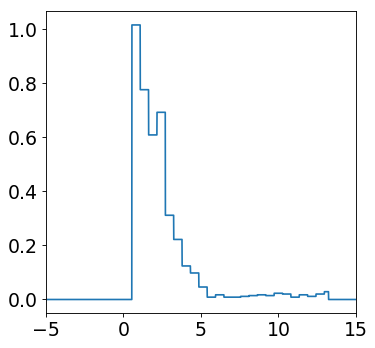

In [46]:
x = np.arange(-50,15,0.01)
plt.figure(figsize=(5,5),dpi=80)
plt.plot(x, WD_MCMC_func.p_merger_delay(x,0,2018))
plt.xlim(-5,15)
plt.show()

/Users/scheng/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


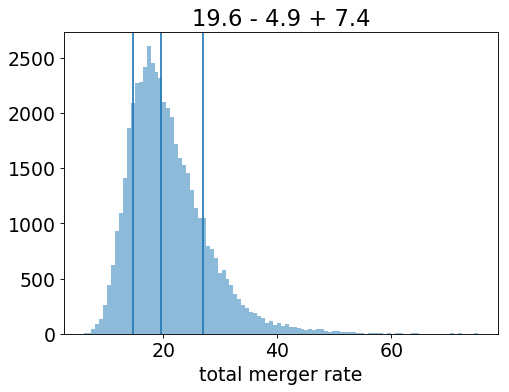

In [47]:
plt.figure(figsize=(7,5),dpi=80)
x = fM+fQ
plt.hist(x,100,alpha=0.5)
plt.axvline(np.percentile(x,16))
plt.axvline(np.percentile(x,50))
plt.axvline(np.percentile(x,84))
plt.title('%.1f - %.1f + %.1f' % (np.percentile(x,50),np.percentile(x,50)-np.percentile(x,16),
      np.percentile(x,84)-np.percentile(x,50)) )
plt.xlabel('total merger rate')
plt.show()

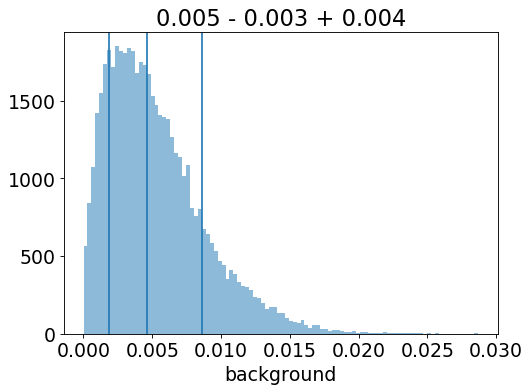

In [48]:
plt.figure(figsize=(7,5),dpi=80)
A = ( ((t_r-9.5)<0)*t_r+((t_r-9.5)>0)*9.5 )/0.743

Ms = 0.083*4/3*np.pi*200**3 * 0.8

x = ((A+1)*fQ )  / (100+A*fQ) * 358 * (fM+fQ)/fQ / (A*0.743+0.743) / Ms * 10**(-9+14)
#x = fQ/(fM+fQ) * 100 # fQ in all merger
#x = ( ((t_r-9.5)<0)*t_r + ((t_r-9.5)>0)*9.5 )/0.743*fQ
x = para_Q[:,2]## beta_z
FQ = fQ/100*(9/0.743+1)/(1+fQ/100*9/0.743)
rate = FQ * 392 * (fQ+fM) / fQ / (9+0.734)
#x = rate
plt.hist(x,100,alpha=0.5)
plt.axvline(np.percentile(x,16))
plt.axvline(np.percentile(x,50))
plt.axvline(np.percentile(x,84))
plt.title('%.3f - %.3f + %.3f' % (np.percentile(x,50),np.percentile(x,50)-np.percentile(x,16),
      np.percentile(x,84)-np.percentile(x,50)) )
plt.xlabel('background')
plt.show()

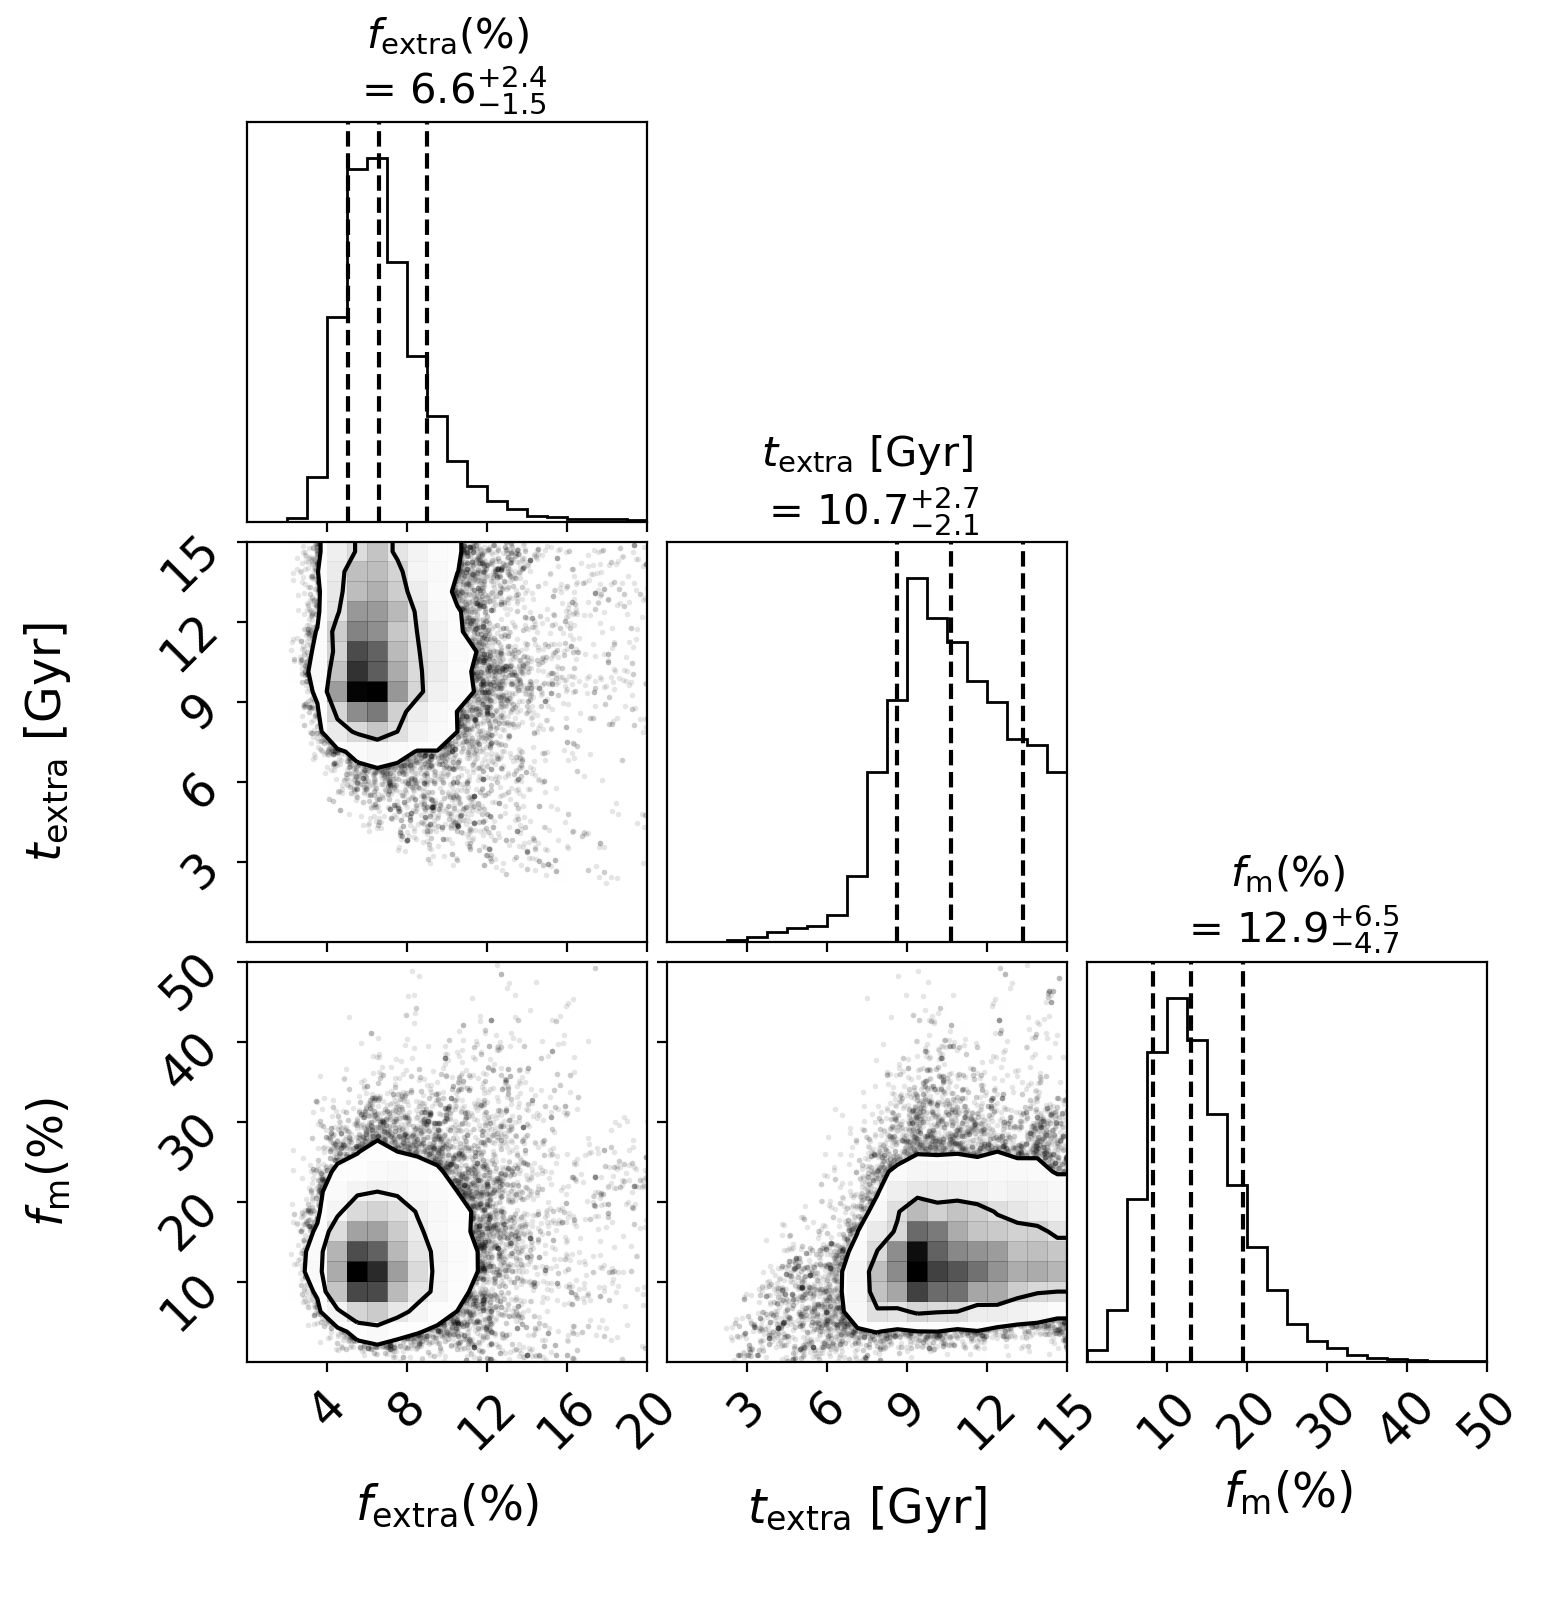

In [49]:
plt.rc('figure',figsize=(7,7),dpi=200)

samples = np.concatenate((fQ, t_r, fM,),axis=1)
corner.corner(samples, labels=["$f_{\\rm extra}(\%)$\n", "$t_{\\rm extra}$ [Gyr]\n", 
                               "$f_{\\rm{m}}(\%)$\n",],
                    quantiles=[0.16, 0.5, 0.84],
                    levels=(0.68,0.90),
                    show_titles=True, title_kwargs={"fontsize": 15},
                    range=[(0,20),(0,15),(0,50),],title_fmt='.1f',
                   )
plt.show()
#truths=np.median(np.concatenate((fQ, t_r, fM),axis=1),axis=0),

In [40]:
plt.rc('figure',figsize=(7,7),dpi=200)

#np.concatenate((para_Q[:,3:4],para_Q[:,4:5],para_Q[:,6:7]),axis=1),"U_Q","V_Q","W_Q"

samples = para_v[:,10:]
fig = corner.corner(samples, labels=[ "U","V","W",
                                    ],
                    quantiles=[0.16, 0.5, 0.84],
                    levels=(0.68,0.90),
                    show_titles=True, title_kwargs={"fontsize": 12},)
                    #range=[(3,13),(3,13),(3,13),])
                    #truths=np.concatenate((para_input[Nv+1:Nv+2],para_input[Nv+5:Nv+6],
                    #                       para_input[10:Nv],
                    #                      para_input[3:5],
                    #                      para_input[6:7])),

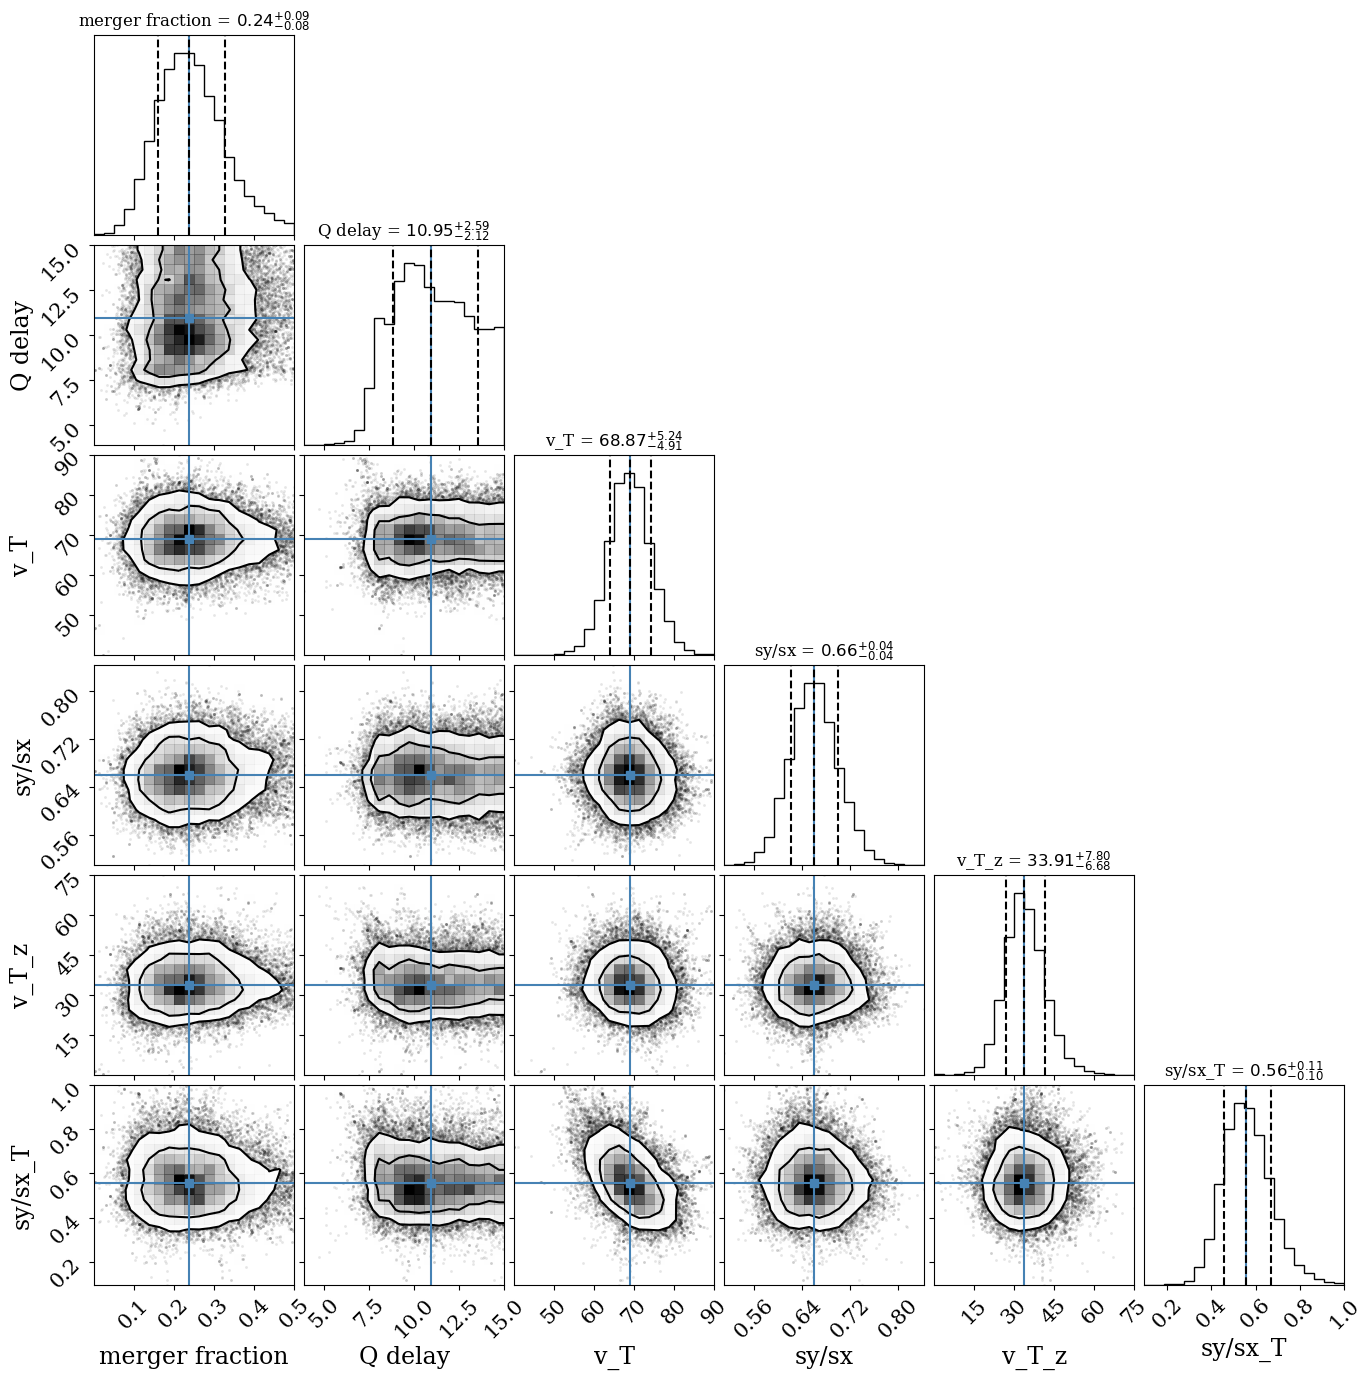

In [9722]:
plt.rc('figure',figsize=(15,15),dpi=100)

samples = np.concatenate((
                          para_Q[:,5:6],
                          para_Q[:,1:2],
                          para_v[:,2:3],
                          para_v[:,5:6],
                         para_v[:,8:9],
                        para_v[:,9:10]),axis=1)

fig = corner.corner(samples, labels=["merger fraction", "Q delay", "v_T",\
                                     "sy/sx","v_T_z","sy/sx_T"],
                    quantiles=[0.16, 0.5, 0.84],
                    levels=(0.68,0.90),
                    show_titles=True, title_kwargs={"fontsize": 12},
                    truths=np.concatenate((
                           para_input[Nv+5:Nv+6],
                           para_input[Nv+1:Nv+2],
                           para_input[2:3],
                           para_input[5:6],
                          para_input[8:10])),
                   )



In [ ]:
%# "power index", "v4", "v_T",
%#"index_z","v4_z",
%#"sy/sx",
%#"v0","v0_z","v_T_z",
%#"sy/sx_T"
%#UVW
%#"fraction", "delay", "background", "SFR_step", "no use", "merger fraction"
%para_v = para[0:Nv].copy()
%para_Q = para[Nv:Nv+NQ].copy()
%if (para_v[0]<0)+(para_v[0]>1)+ (para_v[1]<0)+(para_v[1]>50)+ (para_v[2]<40)+(para_v[2]>90)+\
%    (para_v[3]<0)+(para_v[3]>1)+ (para_v[4]<0)+(para_v[4]>50)+\
%    (para_v[5]<0.0)+(para_v[5]>1)+\
%    (para_v[6]<0)+(para_v[6]>20)+ (para_v[7]<0)+(para_v[7]>20)+ (para_v[8]<0)+(para_v[8]>80)+\
%    (para_v[9]<0.0)+(para_v[9]>1)+\
%    (para_v[10]<-5)+(para_v[10]>20)+\
%    (para_v[11]<-5)+(para_v[11]>20)+\
%    (para_v[12]<-5)+(para_v[12]>20)+\
%    (para_Q[0]<0)+(para_Q[0]>0.35)+\
%    (para_Q[1]<0)+(para_Q[1]>delay_lim)+\
%    (para_Q[2]<0)+(para_Q[2]>0.05)+\
%    (para_Q[3]<-2)+(para_Q[3]>-0.1)+\
%    (para_Q[4]<70)+(para_Q[4]>90)+\
%    (para_Q[5]<0)+(para_Q[5]>0.80)+\
%    (para_Q[6]<-5)+(para_Q[6]>20):

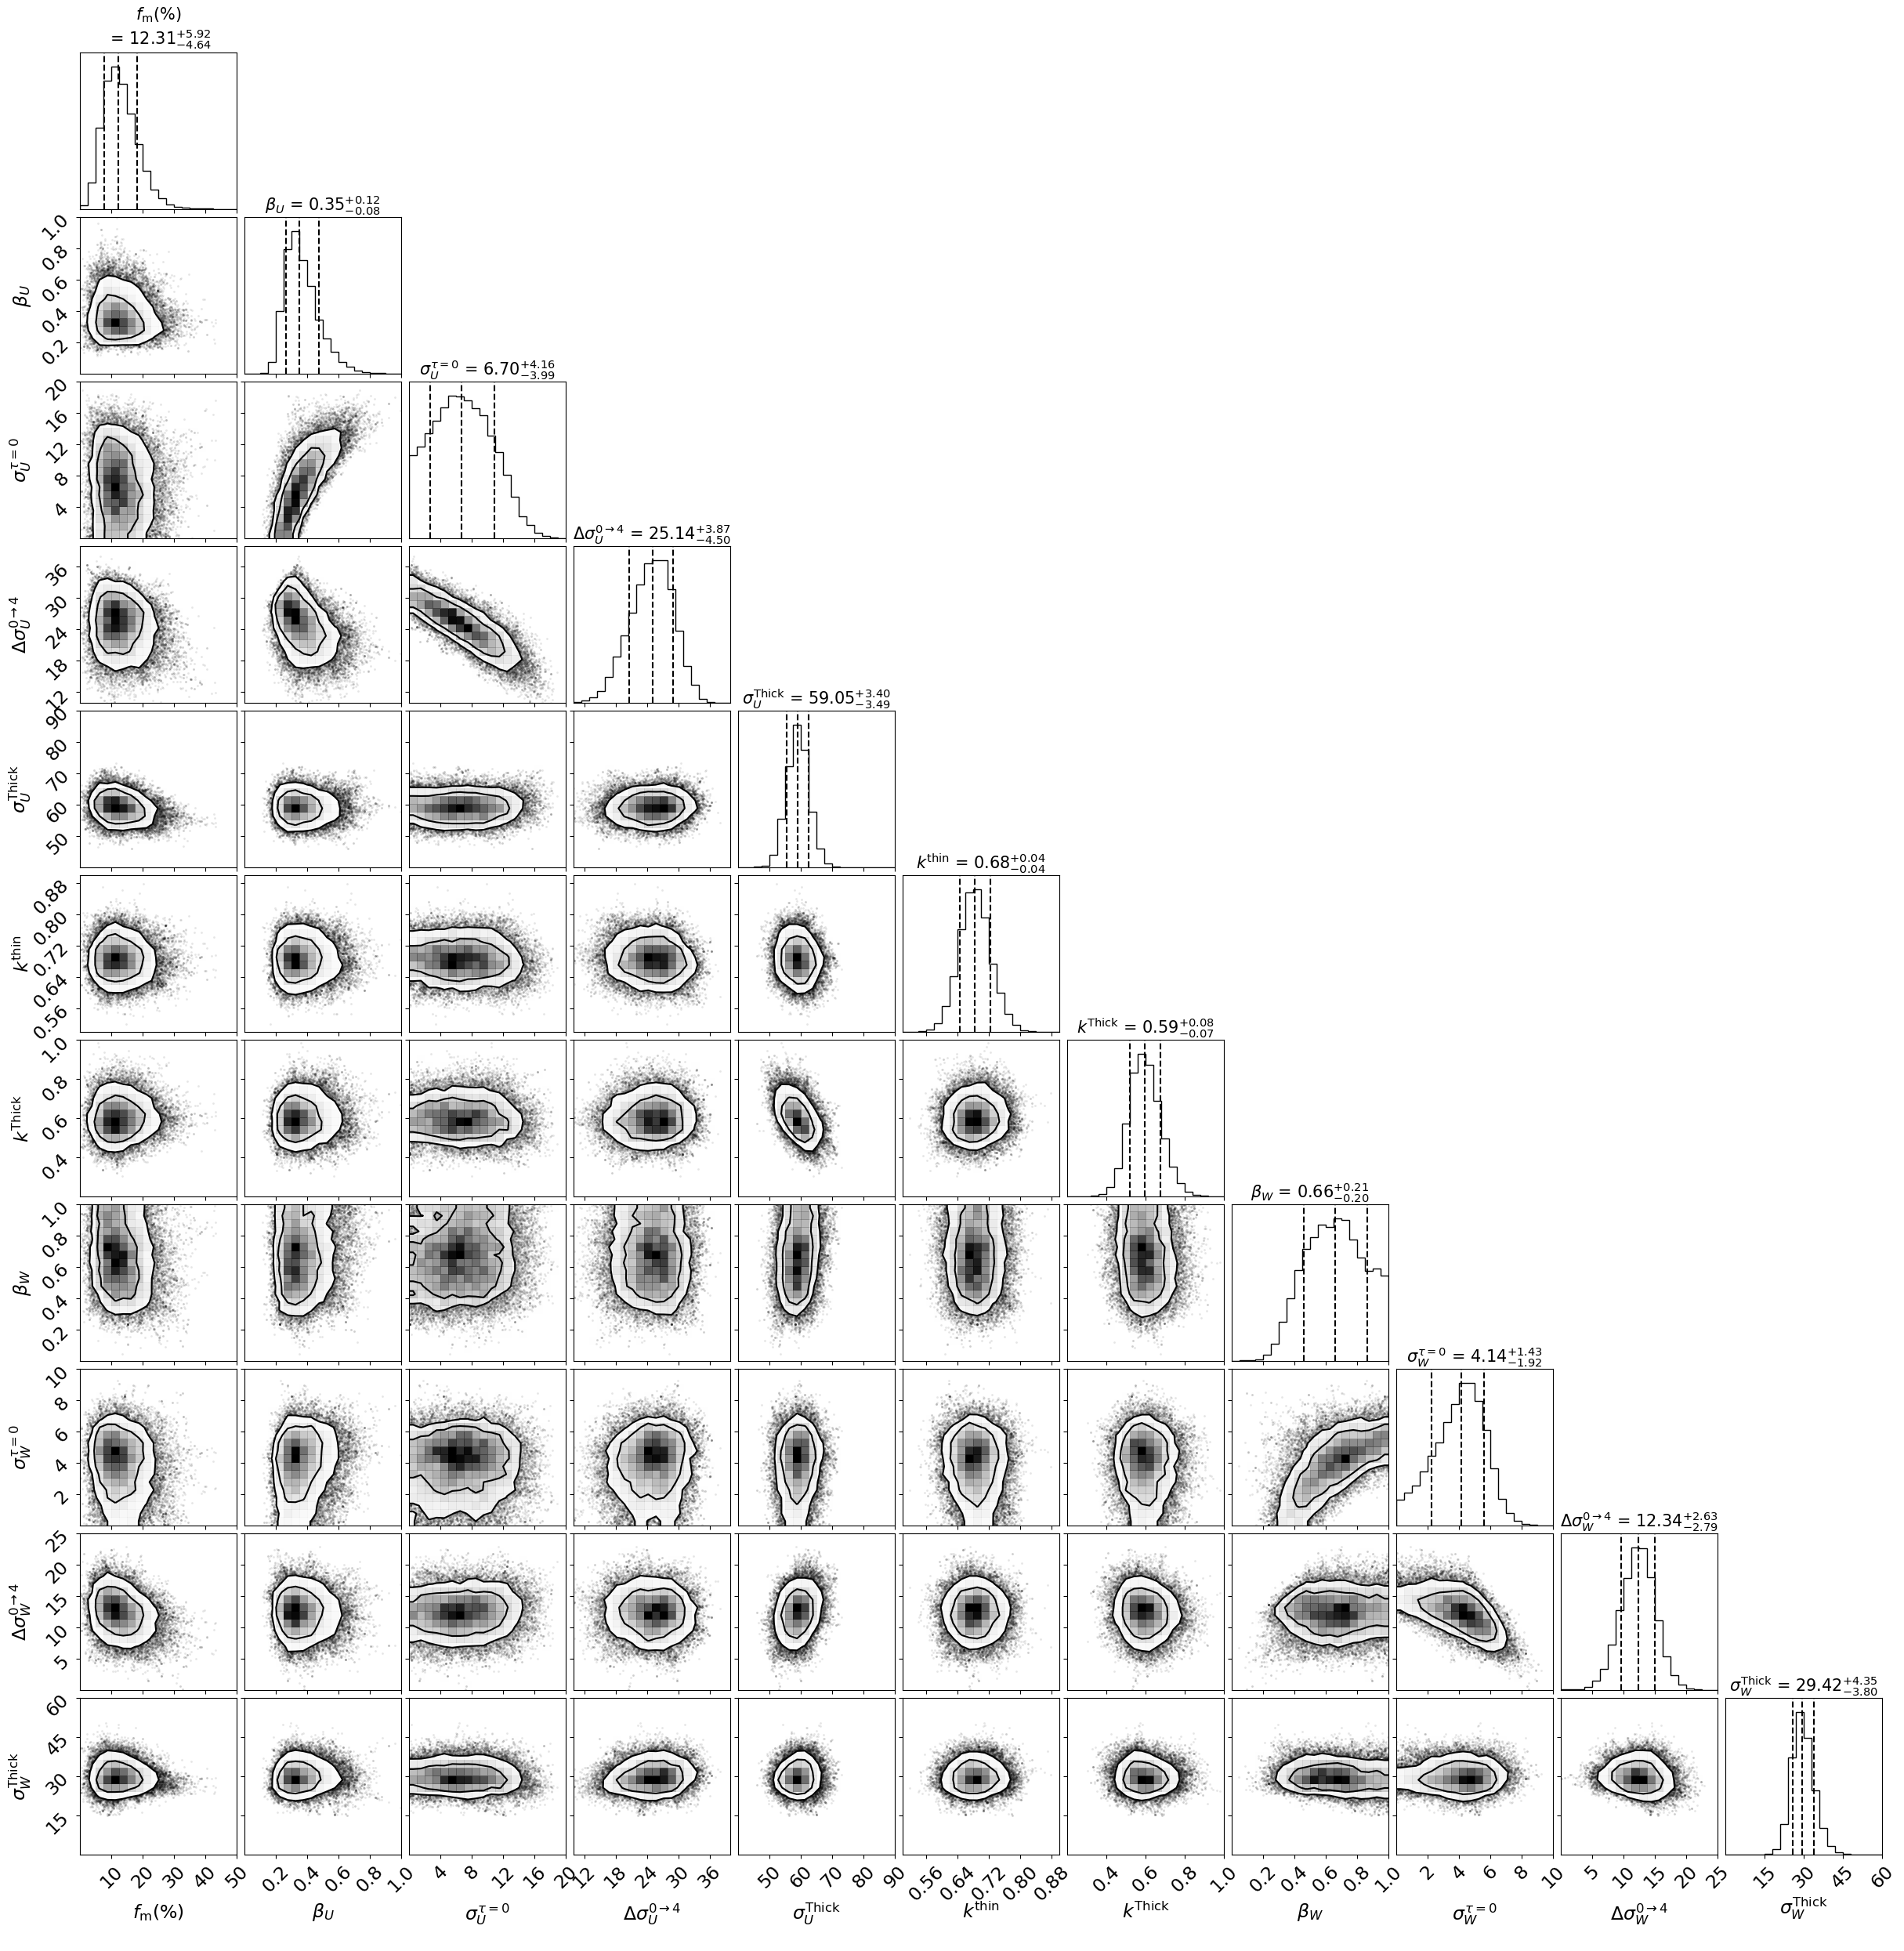

In [217]:
plt.rc('figure',figsize=(15,15),dpi=100)#t_r, fQ, fM, fb, "$t_{\\rm delay}$ [Gyr]\n","$f_{\\rm Q}(\%)$\n",
                                     #"$f_{\\rm m}(\%)$\n","$f_{\\rm bg}(\%)$\n",
samples = np.concatenate((fM, 
                          U_index, v0, v04, vT, 
                          sysx, sysx_T,
                          W_index, v0_W, v04_W, vT_W,
                          ),axis=1)

corner.corner(samples, labels=["$f_{\\rm m}(\%)$\n",
             "$\\beta_U$","$\\sigma_U^{\\tau=0}$","$\\Delta\\sigma_U^{0\\rightarrow4}$","$\\sigma_U^{\\rm Thick}$",
             "$k^{\\rm thin}$","$k^{\\rm Thick}$",
             "$\\beta_W$","$\\sigma_W^{\\tau=0}$","$\\Delta\\sigma_W^{0\\rightarrow4}$","$\\sigma_W^{\\rm Thick}$",
             ],
                    quantiles=[0.16, 0.5, 0.84],
                    levels=(0.68,0.90),
                    show_titles=True, title_kwargs={"fontsize": 15},
              range=[(0,50),
                     (0,1),(0,20),(10,40),(40,90),
                     (0.5,0.9),(0.2,1.0),
                     (0,1),(0,10),(0,25),(0,60)]
                   )
plt.show()

# check goodness of fitting

In [164]:
def get_v_delayed_3D_inverse(age,l,b,vL,vB,factor,v_drift,U,V,W):
    A = 15.3
    B = -11.9
    C = -3.2
    K = -3.3
    d = factor / (1.5*10**8/3600/24/365.24)
        
    pml = ( vL + ( A*np.cos(2*l/180*np.pi)+B-C*np.sin(2*l/180*np.pi) )*np.cos(b/180*np.pi)*d \
           - (V+v_drift)*np.cos(l/180*np.pi)+ U*np.sin(l/180*np.pi)  )/factor
    pmb = ( vB - ( (A*np.sin(2*l/180*np.pi)+C*np.cos(2*l/180*np.pi)+K)*np.sin(2*b/180*np.pi)/2 )*d\
           - W*np.cos(b/180*np.pi) + ((V+v_drift)*np.sin(l/180*np.pi)+U*np.cos(l/180*np.pi))*np.sin(b/180*np.pi)+\
                    v_drift - v_drift  )/factor
    return pml, pmb

def pm_test(para, \
            mass, age, vL, vB, pml, pmb, factor, l, b, selection,\
            mass_Q, age_Q, vL_Q, vB_Q, pml_Q, pmb_Q, factor_Q, l_Q, b_Q, selection_Q):
    # prepare to get v
    para_v = para[:Nv]
    U,V,W = 11,7,6.5
    v_drift = WD_MCMC_func.velocity_scatter_3D(age, para_v[0], para_v[1], para_v[2], para_v[6])**2/80
    v_drift_Q = WD_MCMC_func.velocity_scatter_3D(age_Q, para_v[0], para_v[1], para_v[2], para_v[6])**2/80
    pml, pmb = get_v_delayed_3D_inverse(age, l, b, vL, vB, factor, v_drift,U,V,W)
    pml_Q, pmb_Q = get_v_delayed_3D_inverse(age_Q, l_Q, b_Q, vL_Q, vB_Q, factor_Q, v_drift_Q,U,V,W)
    return pml, pmb, pml_Q, pmb_Q

In [51]:
# "power index", "v10", "v_T",
#"index_z","v10_z",
#"sy/sx",
#"v0","v0_z","v_T_z","sy/sx_T"

In [52]:
np.median(para_v,axis=0), np.median(para_Q,axis=0)

(array([  0.37106997,  25.30786934,  65.10172972,   0.66960211,
         11.74349557,   0.67792557,   6.83125927,   4.27446248,
         32.06478715,   0.5762003 ,  10.40272896,   7.18373637,   6.59334853]),
 array([  6.56969917e-02,   1.06516280e+01,   4.58892627e-03,
         -8.89771342e-01,   8.05031042e+01,   1.29325023e-01,
          7.88869925e+00]))

In [220]:
importlib.reload(WD_MCMC_func)
WD_MCMC_func.age_T = 7
SFR_TYPE = 2
para_MCMC_best = np.array([0.36, 27, 59,
                 0.62, 13,
                 0.66,
                 7.3 ,4 ,29 ,0.61,
                 10,7.5,6.5,
                 0.19, 11 ,0.0037 , -13, 0.5, 0.165, 5]) # SFR2 MCMC 0.75:0.09
para_MCMC_best = np.concatenate((np.median(para_v,axis=0), np.median(para_Q,axis=0)))
para_noQ = para_MCMC_best.copy()
para_noQ[13] = 0
para_noQ[18] = para_MCMC_best[18]/(1-para_MCMC_best[13]-para_MCMC_best[18])
para_nomerger = para_noQ.copy()
para_nomerger[18] = 0
U,V,W = 11,7,6.5

In [162]:
importlib.reload(WD_MCMC_func)
WD_MCMC_func.age_T = 7
#data = np.load('/datascope/menard/group/scheng/Gaia/WD_vel_age_MCMC_Feb12/\
#MCMC_power_2018_0_1.07_250_3.5_DA_thick_ONe_11_T7_FFF2.npy')[0]
#para_v = data['para_v'][-50000:,:]#[selected]
#para_Q = data['para_Q'][-50000:,:]#[selected]
#para_MCMC_best_2018 = np.concatenate((np.median(para_v,axis=0), np.median(para_Q,axis=0)))

#data = np.load('MCMC_power_-0.7_0.5_1.08_250_3.5_DA_thick_ONe_11_T6_FFF3Qisnotmerger.npy')[0]
data = np.load('MCMC_power_-0.7_0.5_1.08_250_3.5_DA_thick_ONe_11_T7_FFF2Qisnotmerger.npy')[0]
para_v = data['para_v'][-50000:,:]#[selected]
para_Q = data['para_Q'][-50000:,:]#[selected]
para_MCMC_best_Qisnotmerger = np.concatenate((np.median(para_v,axis=0), np.median(para_Q,axis=0)))

#data = np.load('MCMC_power_-0.7_0.5_1.08_250_3.5_DA_thick_ONe_11_T6_FFF3.npy')[0]
data = np.load('MCMC_power_-0.7_0.5_1.08_250_3.5_DA_thick_ONe_11_T7_FFF2.npy')[0]
para_v = data['para_v'][-50000:,:]#[selected]
para_Q = data['para_Q'][-50000:,:]#[selected]
para_MCMC_best = np.concatenate((np.median(para_v,axis=0), np.median(para_Q,axis=0)))

#
#data = np.load('/datascope/menard/group/scheng/Gaia/WD_vel_age_MCMC_Feb12/\
#MCMC_power_2018_0_1.075_250_3.5_DA_thick_ONe_11_T7_FFFnoQ.npy')[0]
#para_v = data['para_v'][-50000:,:]#[selected]
#para_Q = data['para_Q'][-50000:,:]#[selected]
#para_noQ = np.concatenate((np.median(para_v,axis=0), np.median(para_Q,axis=0)))
#para_noQ[13] = 0
#
data = np.load('MCMC_power_-0.7_0.5_1.08_250_3.5_DA_thick_ONe_11_T7_FFF2.npy')[0]
para_v = data['para_v'][-50000:,:]#[selected]
para_Q = data['para_Q'][-50000:,:]#[selected]
para_nomerger = np.concatenate((np.median(para_v,axis=0), np.median(para_Q,axis=0)))
para_nomerger[13] = 0
para_nomerger[18] = 0

U,V,W = 11,7,6.5

In [163]:
distance1 = 0
distance2 = 250
mass_min = 1.08
mass_max = 1.23#1.27
spec_type = 'DA_thick'
model = 'ONe'
age_lim = 3.5

#!scp 'scheng@dslogin01.pha.jhu.edu:/datascope/menard/group/scheng/Gaia/WD_warwick_smaller.npy' '.'
WD_warwick_smaller = np.load('WD_warwick_smaller.npy')[0]['WD_warwick_smaller']
#WD_warwick_smaller = np.load('/datascope/menard/group/scheng/Gaia/WD_warwick_smaller.npy')[0]['WD_warwick_smaller']
_, WD_warwick_smaller = WD_MCMC_func.select_WD(WD_warwick_smaller,1.4,0.10,2,22,8,300) # changed on Dec 18

WD_warwick_smaller['mass'] = WD_warwick_smaller['mass_'+spec_type+'_'+model]
WD_warwick_smaller['age'] = WD_warwick_smaller['age_'+spec_type+'_'+model]
Q_branch = np.array((WD_warwick_smaller['mass']>mass_min)*(WD_warwick_smaller['mass']<mass_max)*\
         (1/WD_warwick_smaller['parallax']*1000>distance1)*(1/WD_warwick_smaller['parallax']*1000<distance2)*\
        (WD_HR.func_select(WD_warwick_smaller['bp_rp'],WD_warwick_smaller['G'],13.20,1.2,0.20,-0.40,0.10)) )
WD = WD_warwick_smaller[np.array((WD_warwick_smaller['mass']>mass_min)*(WD_warwick_smaller['mass']<mass_max)*\
        (1/WD_warwick_smaller['parallax']*1000>distance1)*(1/WD_warwick_smaller['parallax']*1000<distance2)\
         * ~Q_branch )]
WD_Q = WD_warwick_smaller[Q_branch]

print('length of WD: ',len(WD), 'length of WD_Q: ',len(WD_Q))


# prepare to get v
pml,pmb,factor = WD_MCMC_func.prep_get_v(WD)
pml_Q, pmb_Q, factor_Q = WD_MCMC_func.prep_get_v(WD_Q)
v_drift = (((WD['age']+0.1)/10.1)**0.2*40)**2/80
v_drift_Q = (((WD_Q['age']+0.1)/10.1)**0.2*40)**2/80
vL, vB = np.array(WD_MCMC_func.get_v_delayed_3D(WD['age'], WD['l'], WD['b'], pml, pmb,
                                                factor, v_drift,11,7.5,7))
vL_Q, vB_Q = np.array(WD_MCMC_func.get_v_delayed_3D(WD_Q['age'], WD_Q['l'], WD_Q['b'], pml_Q, pmb_Q,
                                                    factor_Q, v_drift_Q, 11,7.5,7))

selection = np.array(((WD['age'])<age_lim)*((WD['age'])>0.1)*(np.abs(vL<200))*(np.abs(vB<200)))
mass = np.array(WD['mass'][selection])
age = np.array(WD['age'][selection])
l = np.array(WD['l'][selection])
b = np.array(WD['b'][selection])
vL = vL[selection]
vB = vB[selection]
pml = pml[selection]
pmb = pmb[selection]
factor = factor[selection]

selection_Q = np.array(((WD_Q['age'])<age_lim)*((WD_Q['age'])>0.1)*(np.abs(vL_Q<200))*(np.abs(vB_Q<200)))
mass_Q = np.array(WD_Q['mass'][selection_Q])
age_Q = np.array(WD_Q['age'][selection_Q])
l_Q = np.array(WD_Q['l'][selection_Q])
b_Q = np.array(WD_Q['b'][selection_Q])
vL_Q = vL_Q[selection_Q]
vB_Q = vB_Q[selection_Q]
pml_Q = pml_Q[selection_Q]
pmb_Q = pmb_Q[selection_Q]
factor_Q = factor_Q[selection_Q]
print(selection.sum(),selection_Q.sum(),selection.sum()+selection_Q.sum())

early = np.array(1.22 - (age - 0.6) * 0.2> mass) #for ONe: 1.22; CO: 1.25
late = np.array(1.22 - (age - 0.6) * 0.2 < mass) 

84723
length of WD:  617 length of WD_Q:  510


/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


556 510 1066


In [165]:
n_v_bin = 200
v_limit = 200

def simulate_vBvL_distribution(para, n_v_bin, v_limit, NOT_FIT_UVW=False,NOT_FIT_INDEX=False,FIXV=False):
    early_v = np.empty((n_v_bin,2))
    late_v = np.empty((n_v_bin,2))
    Q_v = np.empty((n_v_bin,2))
    v_test = np.linspace(-v_limit,v_limit,n_v_bin)
    
    for i,v in enumerate(v_test):
        vL_test = np.ones_like(vL)*v
        vB_test = np.ones_like(vB)*v
        vL_Q_test = np.ones_like(vL_Q)*v
        vB_Q_test = np.ones_like(vB_Q)*v
        
        pml_test, pmb_test, pml_Q_test, pmb_Q_test =\
                pm_test(para, \
                        mass, age, vL_test, vB_test, pml, pmb, factor, l, b, selection,\
                        mass_Q, age_Q, vL_Q_test, vB_Q_test, pml_Q, pmb_Q, factor_Q, l_Q, b_Q, selection_Q)
    
        _,early_vL,late_vL,Q_vL = WD_MCMC_func.ln_likelihood_pheno(para,\
                        mass, age, pml_test, pmb_test*0, factor, l, b,\
                        mass_Q, age_Q, pml_Q_test, pmb_Q_test*0, factor_Q, l_Q, b_Q,\
                        True, WD_MCMC_func.velocity_density_3D_check, True,NOT_FIT_UVW,NOT_FIT_INDEX,FIXV)
    
        _,early_vB,late_vB,Q_vB = WD_MCMC_func.ln_likelihood_pheno(para,\
                        mass, age, pml_test*0, pmb_test, factor, l, b,\
                        mass_Q, age_Q, pml_Q_test*0, pmb_Q_test, factor_Q, l_Q, b_Q,\
                        True, WD_MCMC_func.velocity_density_3D_check, False,NOT_FIT_UVW,NOT_FIT_INDEX,FIXV)
        early_v[i,0] = np.exp(early_vL).mean()
        late_v[i,0] = np.exp(late_vL).mean()
        Q_v[i,0] = np.exp(Q_vL).mean()
        early_v[i,1] = np.exp(early_vB).mean()
        late_v[i,1] = np.exp(late_vB).mean()
        Q_v[i,1] = np.exp(Q_vB).mean()
        
    GOF = {'early_v':early_v,
           'late_v':late_v,
            'Q_v':Q_v,
            'v_test':v_test }
    return GOF

In [166]:
GOF_withQ = simulate_vBvL_distribution(para_MCMC_best,200,200)

In [167]:
#GOF_withQ_2018 = simulate_vBvL_distribution(para_MCMC_best_2018,200,200)

In [168]:
GOF_withQ_Qisnotmerger = simulate_vBvL_distribution(para_MCMC_best_Qisnotmerger,200,200)

In [169]:
#GOF_noQ = simulate_vBvL_distribution(para_noQ,200,200)

In [170]:
GOF_nomerger = simulate_vBvL_distribution(para_nomerger,200,200)

In [171]:
early.sum(),late.sum(),len(vL_Q)

(304, 252, 510)

In [172]:
np.save('GOF.npy', np.array([{'GOF_withQ':GOF_withQ, 
         'GOF_withQ_Qisnotmerger':GOF_withQ_Qisnotmerger, 
         'GOF_nomerger':GOF_nomerger}]) )
data = np.load('GOF.npy')[0]
GOF_withQ, GOF_withQ_Qisnotmerger, GOF_nomerger = \
                    data['GOF_withQ'], data['GOF_withQ_Qisnotmerger'], data['GOF_nomerger']

In [209]:
hist_bin = 31
number_factor = v_limit*2
hist_range = np.array([-v_limit,v_limit])
    
def plot_GOF_new(GOF_0, GOF_1, GOF_2, figsize=(15,7), xlim=(-150,150),ylim=[0.05,100],islog=True,
                labels=['best fit of setup 1 (all extra-delayed WDs also have merger delay)',
                        'best fit of setup 2 (no extra-delayed WDs has merger delay)',
                        'no evolutionary delay']):
    plt.figure(figsize=figsize,dpi=200)
    tick_size = 21
    label_size = 23
    
    early = np.array(1.22 - (age - 0.6) * 0.2> mass) #for ONe: 1.22; CO: 1.25
    late = np.array(1.22 - (age - 0.6) * 0.2 < mass) 
        
    xlabel = ['','$v_L$ [km/s]','$v_L$ [km/s]','$v_L$ [km/s]','$v_B$ [km/s]','$v_B$ [km/s]','$v_B$ [km/s]']
    label = ['','early','Q branch','late','early','Q branch','late']
    color = ['','lightseagreen','olivedrab','firebrick','lightseagreen','olivedrab','firebrick']
    color = ['','lightseagreen','r','lightseagreen','lightseagreen','r','lightseagreen']
    offset = [0,-1,-1,-1,0.5,0.5,0.5]
    offset = [0,0,0,0,0,0,0]
    
    early_v = GOF_0['early_v']; late_v = GOF_0['late_v']; Q_v = GOF_0['Q_v']; v_test = GOF_0['v_test']
    curve_content_0 = ['',early_v[:,0],Q_v[:,0],late_v[:,0],early_v[:,1],Q_v[:,1],late_v[:,1]]
    early_v = GOF_1['early_v']; late_v = GOF_1['late_v']; Q_v = GOF_1['Q_v']; v_test = GOF_1['v_test']
    curve_content_1 = ['',early_v[:,0],Q_v[:,0],late_v[:,0],early_v[:,1],Q_v[:,1],late_v[:,1]]
    early_v = GOF_2['early_v']; late_v = GOF_2['late_v']; Q_v = GOF_2['Q_v']; v_test = GOF_2['v_test']
    curve_content_2 = ['',early_v[:,0],Q_v[:,0],late_v[:,0],early_v[:,1],Q_v[:,1],late_v[:,1]]
    
    hist_content = ['',vL[early],vL_Q,vL[late],vB[early],vB_Q,vB[late]]
    #7.65614771e-02, 1.06139514e+01, 5.25411640e-03, 8.03484908e+00,
    #    7.88911628e+00, 1.16808261e-01
    lw = 1.5
    for i in range(1,7):
        ax = plt.subplot(2,3,i)
        plt.plot(v_test+offset[i],curve_content_0[i]*len(hist_content[i])*number_factor/hist_bin,
                 color=color[i],lw=lw)
        plt.plot(v_test+offset[i],curve_content_1[i]*len(hist_content[i])*number_factor/hist_bin,
                 color=color[i],ls='dashed',lw=lw)
        plt.plot(v_test+offset[i],curve_content_2[i]*len(hist_content[i])*number_factor/hist_bin,
                 color='k',ls='dotted',lw=lw)
        hist, bins = np.histogram(hist_content[i],hist_bin,hist_range)
        plt.errorbar((bins[:-1]+bins[1:])/2, hist, hist**0.5, 0, '.',color=color[i],lw=1,ms=10)
        if islog==True:
            plt.yscale('log')
            if i%3==1:
                plt.yticks([1,10,100],['1','10','100'],fontsize=tick_size)
            else:
                plt.yticks([],[],fontsize=tick_size)
        else:
            plt.yticks([0,40,80],fontsize=tick_size)
        plt.xticks(fontsize=tick_size);
        
        plt.ylim(ylim[0],ylim[1])
        plt.xlim(xlim[0],xlim[1])
        if i==1:
            #plt.ylabel('count per bin',fontsize=label_size,family='serif',local)
            plt.text(-0.25,0,'count per bin',horizontalalignment='center',rotation=90,
                 verticalalignment='center', transform=ax.transAxes,fontsize=label_size)
            plt.plot([1000,1000],[1,2],
                 color='gray',label=labels[0],lw=lw)
            plt.plot([400,400],[1,2],
                 color='gray',ls='dashed',label=labels[1],lw=lw)
            plt.plot([400,400],[1,2],
                 color='k',ls='dotted',label=labels[2],lw=lw)
            plt.errorbar(-200, 1, 0, None,'.',color='k',lw=1,ms=10,label='observed velocity histogram')
            plt.legend(fontsize=tick_size-4, loc=(0,1.05))
        if i<=3:
            #plt.title(label[i], fontsize=label_size, color=color[i])
            plt.setp(ax.get_xticklabels(), visible=False)
            plt.text(0.95, 0.95, '$v_L$', horizontalalignment='right',
                 verticalalignment='top', transform=ax.transAxes,fontsize=label_size)
            plt.text(0.05, 0.95, label[i], color=color[i], horizontalalignment='left',
                 verticalalignment='top', transform=ax.transAxes,fontsize=tick_size)
        if i>3:
            plt.xlabel('velocity $[\\rm km\,s^{-1}]$',fontsize=label_size)
            plt.text(0.95, 0.95, '$v_B$', horizontalalignment='right',
                 verticalalignment='top', transform=ax.transAxes,fontsize=label_size)
        cdf = interp1d(v_test+offset[i], np.cumsum(curve_content_2[i])*number_factor/n_v_bin,
                        bounds_error=False, fill_value=(0,1))
        s,p = kstest(hist_content[i], cdf, args=(), N=20, alternative='two-sided', mode='approx')
        #plt.text(0.05, 0.95, 'p-value: %.3f\n(KS test)' % p, horizontalalignment='left',
        #         verticalalignment='top', transform=ax.transAxes,fontsize=tick_size, family='serif')
        plt.subplots_adjust(wspace =0.1, hspace =0.0)#调整子图间距
    plt.show()

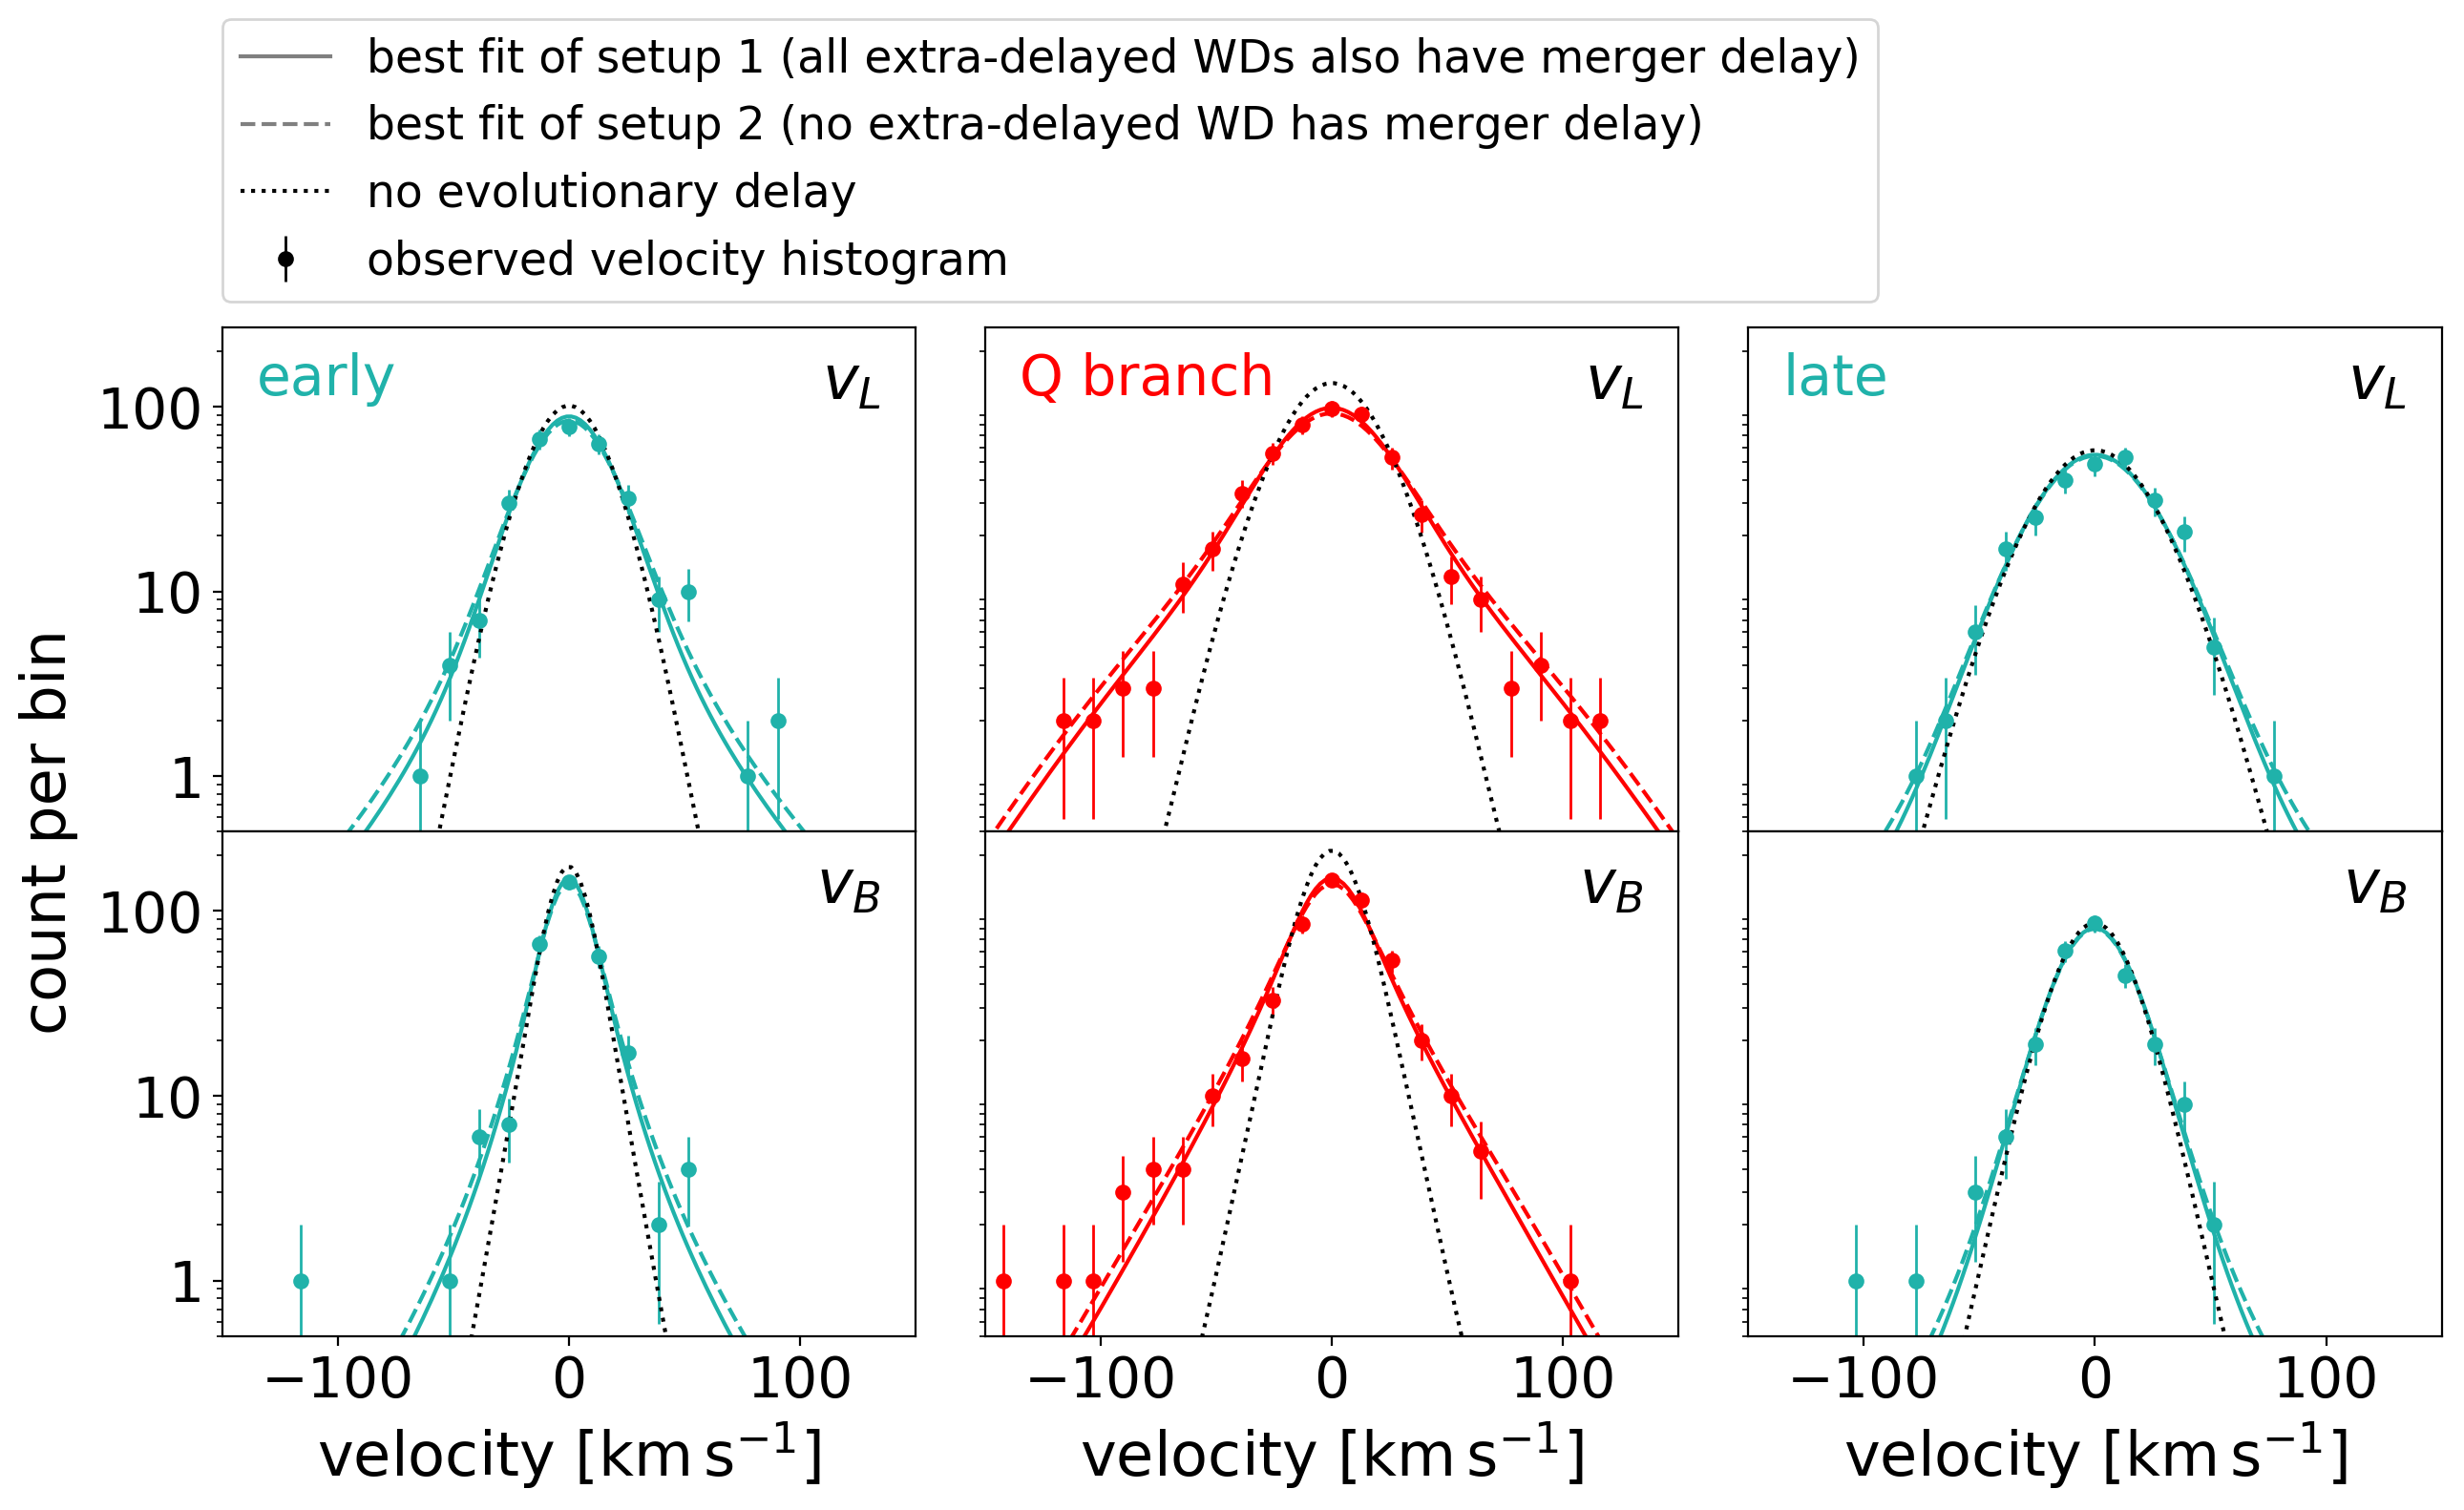

In [180]:
from scipy.stats import kstest
plot_GOF_new(GOF_withQ, GOF_withQ_Qisnotmerger, GOF_nomerger, figsize=(15,7), islog=True,
             ylim=(0.5,1*25000/hist_bin/3),
             labels=['best fit of setup 1 (all extra-delayed WDs also have merger delay)',
                     'best fit of setup 2 (no extra-delayed WD has merger delay)',
                     'no evolutionary delay',
                     ])
#plot_GOF_new(GOF_withQ, GOF_noQ, GOF_nomerger, figsize=(15,7), islog=True,ylim=(0.05,1*25000/hist_bin/5))

In [346]:
hist_bin = 52
number_factor = v_limit*2
hist_range = np.array([-v_limit,v_limit])
    
def plot_GOF_poster(GOF_0, GOF_1, figsize=(15,4), xlim=(-150,150),ylim=[0.05,100],islog=True,
                labels=['best fit','without the Q-delayed pop.','without merger and Q-delayed pop.']):
    plt.figure(figsize=figsize,dpi=200)
    tick_size = 15
    label_size = 17
    title_size = 20
    
    early = np.array(1.22 - (age - 0.6) * 0.2 > mass) #for ONe: 1.22; CO: 1.25
    late = np.array(1.22 - (age - 0.6) * 0.2 < mass) 
        
    xlabel = ['','$v_L$ [km/s]','$v_L$ [km/s]','$v_L$ [km/s]','$v_B$ [km/s]','$v_B$ [km/s]','$v_B$ [km/s]']
    label = ['','early','Q branch','late','early','Q branch','late']
    color = ['','lightseagreen','olivedrab','firebrick','lightseagreen','olivedrab','firebrick']
    color = ['','lightseagreen','r','lightseagreen','lightseagreen','r','lightseagreen']
    offset = [0,-1,-1,-1,1,1,1]
    offset = [0,0,0,0,0,0,0]
    
    early_v = GOF_0['early_v']; late_v = GOF_0['late_v']; Q_v = GOF_0['Q_v']; v_test = GOF_0['v_test']
    curve_content_0 = ['',early_v[:,0],Q_v[:,0],late_v[:,0],early_v[:,1],Q_v[:,1],late_v[:,1]]
    early_v = GOF_1['early_v']; late_v = GOF_1['late_v']; Q_v = GOF_1['Q_v']; v_test = GOF_1['v_test']
    curve_content_1 = ['',early_v[:,0],Q_v[:,0],late_v[:,0],early_v[:,1],Q_v[:,1],late_v[:,1]]
    
    hist_content = ['',vL[early],vL_Q,vL[late],vB[early],vB_Q,vB[late]]
    #7.65614771e-02, 1.06139514e+01, 5.25411640e-03, 8.03484908e+00,
    #    7.88911628e+00, 1.16808261e-01
    for i in range(1,7):
        ax = plt.subplot(2,3,i)
        plt.plot(v_test+offset[i],(curve_content_0[i]+curve_content_0[i][::-1])*len(hist_content[i])*number_factor/hist_bin,
                 color=color[i])
        plt.plot(v_test+offset[i],(curve_content_1[i]+curve_content_1[i][::-1])*len(hist_content[i])*number_factor/hist_bin,
                 color='k',linestyle='dotted')
        hist, bins = np.histogram(hist_content[i],hist_bin,hist_range)
        plt.errorbar((bins[:-1]+bins[1:])/2, (hist+hist[::-1]), (hist+hist[::-1])**0.5, 0, '.',color=color[i],lw=1,ms=10)
        if islog==True:
            plt.yscale('log')
            if i%3==1:
                plt.yticks([1,10,100],['1','10','100'],fontsize=tick_size,family='serif')
            else:
                plt.yticks([],[],fontsize=tick_size,family='serif')
        else:
            if i%3==1:
                plt.yticks([0,50,100],fontsize=tick_size,family='serif')
            else:
                plt.yticks([],[],fontsize=tick_size,family='serif')
        plt.xticks(fontsize=tick_size,family='serif');
        
        plt.ylim(ylim[0],ylim[1])
        plt.xlim(xlim[0],xlim[1])
        if i==1:
            #plt.ylabel('count per bin',fontsize=label_size,family='serif',local)
            plt.text(-0.3,0,'count per bin',horizontalalignment='center',rotation=90,
                 verticalalignment='center', transform=ax.transAxes,fontsize=label_size, family='serif')
            l1, = plt.plot([1000,1000],[1,2],
                 color='gray',label=labels[0])
            l2, = plt.plot([1000,1000],[1,2],
                 linestyle='dotted', color='k',label=labels[1])
            h1 = plt.errorbar(-200, 1, 0, None,'.',color='k',lw=1,ms=10,label=labels[2])
            plt.legend(handles=[h1, l1, l2], fontsize=15,loc=(0,1.1))
        if i<=3:
            #plt.title(label[i], fontsize=title_size, color=color[i])
            #plt.setp(ax.get_xticklabels(), visible=False)
            plt.text(0.95, 0.95, '$v_L$', horizontalalignment='right',
                 verticalalignment='top', transform=ax.transAxes,fontsize=20)
            plt.text(0.25, 0.95, label[i], color=color[i], horizontalalignment='left',
                 verticalalignment='top', transform=ax.transAxes,fontsize=tick_size, family='serif')
            plt.xlabel('velocity [km/s]',fontsize=label_size,family='serif')
            plt.xticks([])
        if i>3:
            plt.xlabel('velocity [km/s]',fontsize=label_size,family='serif')
            plt.text(0.95, 0.95, '$v_B$', horizontalalignment='right',
                 verticalalignment='top', transform=ax.transAxes,fontsize=20)
        cdf = interp1d(v_test+offset[i], np.cumsum(curve_content_0[i])*number_factor/n_v_bin,
                        bounds_error=False, fill_value=(0,1))
        s,p = kstest(hist_content[i], cdf, args=(), N=20, alternative='two-sided', mode='approx')
        #plt.text(0.05, 0.95, 'p-value: %.3f\n(KS test)' % p, horizontalalignment='left',
        #         verticalalignment='top', transform=ax.transAxes,fontsize=tick_size, family='serif')
        plt.subplots_adjust(wspace =0., hspace =0.0)#调整子图间距
    plt.show()

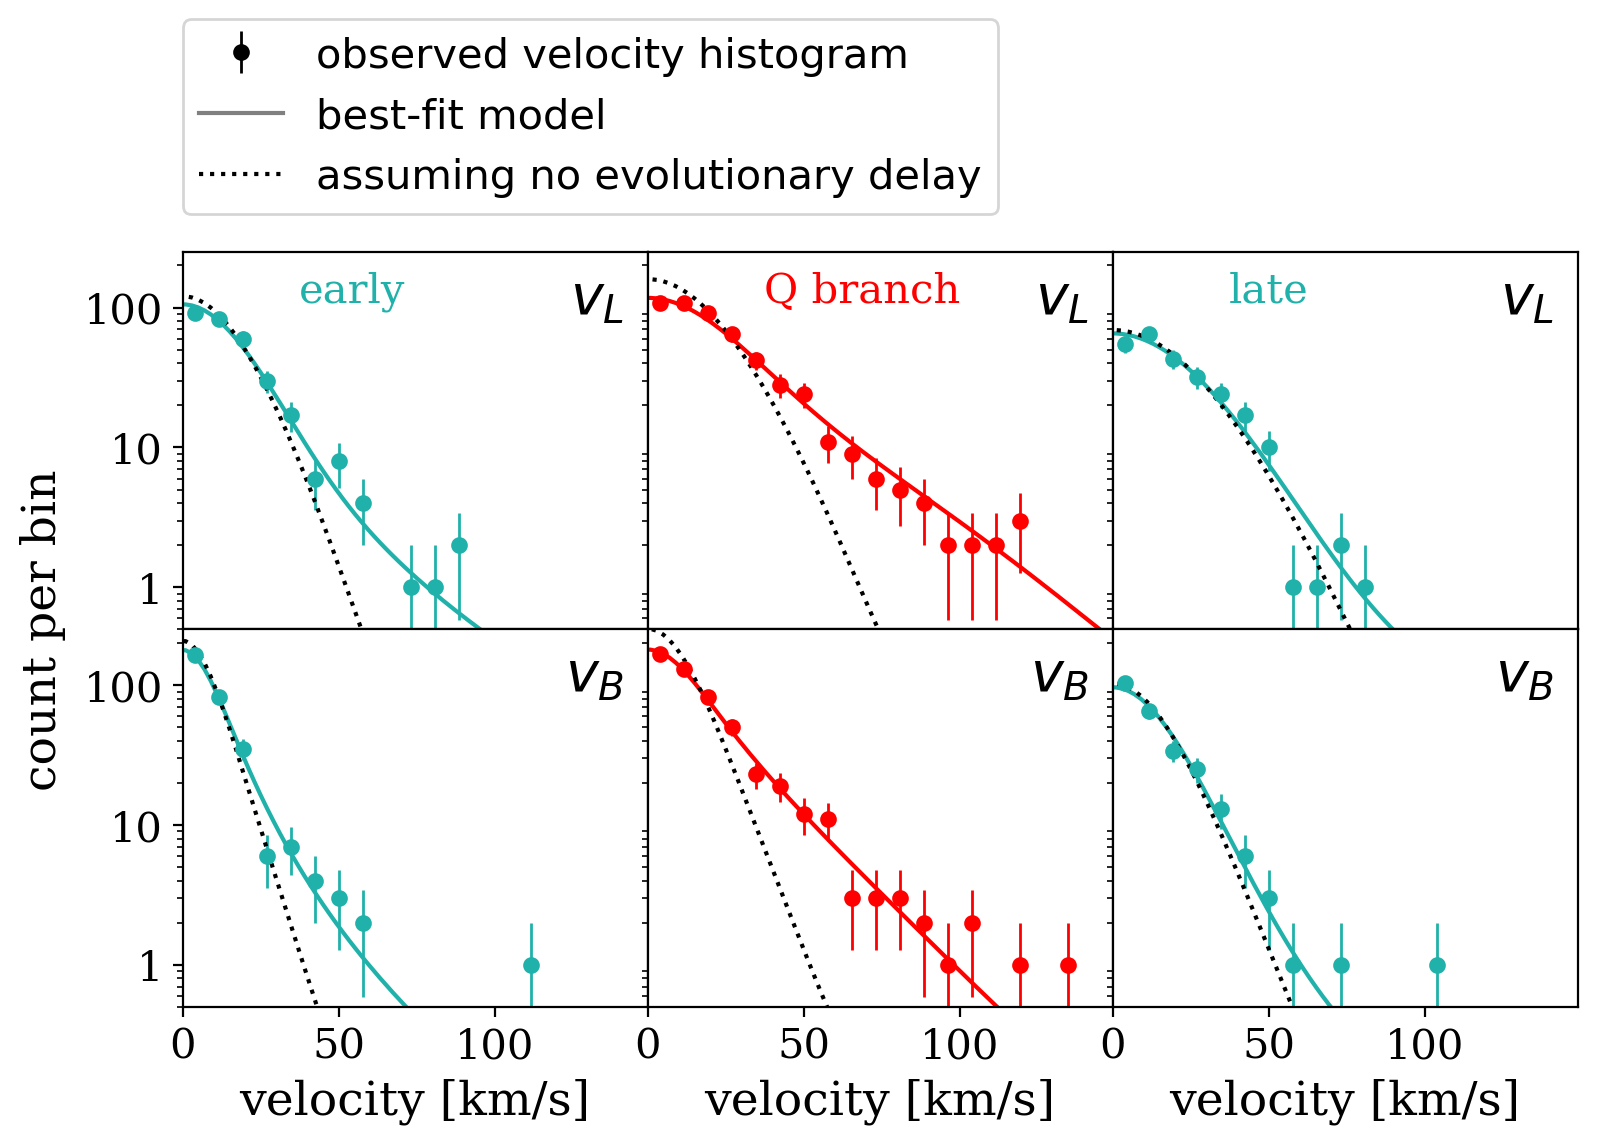

In [348]:
plot_GOF_poster(GOF_withQ, GOF_nomerger, figsize=(9,5), islog=True,
             ylim=(0.5,250), xlim=(0,149),
             labels=['best-fit model',
                     'assuming no evolutionary delay',
                     'observed velocity histogram',
                     ]) # ylim=(0.5,1*25000/hist_bin/3),

In [266]:
plt.plot(t0, velocity_scatter_3D(t0, para[0], para[1], para[2], para[6]))
plt.plot(t0, velocity_scatter_3D(t0, para[0], para[1]*np.sqrt(para[5]), para[2]*np.sqrt(para[9]),\
                             para[6]*np.sqrt(para[5])) )
plt.plot(t0, velocity_scatter_3D(t0, para[3], para[4], para[8], para[7]) )
plt.ylim(0)
plt.show()

NameError: name 'para' is not defined

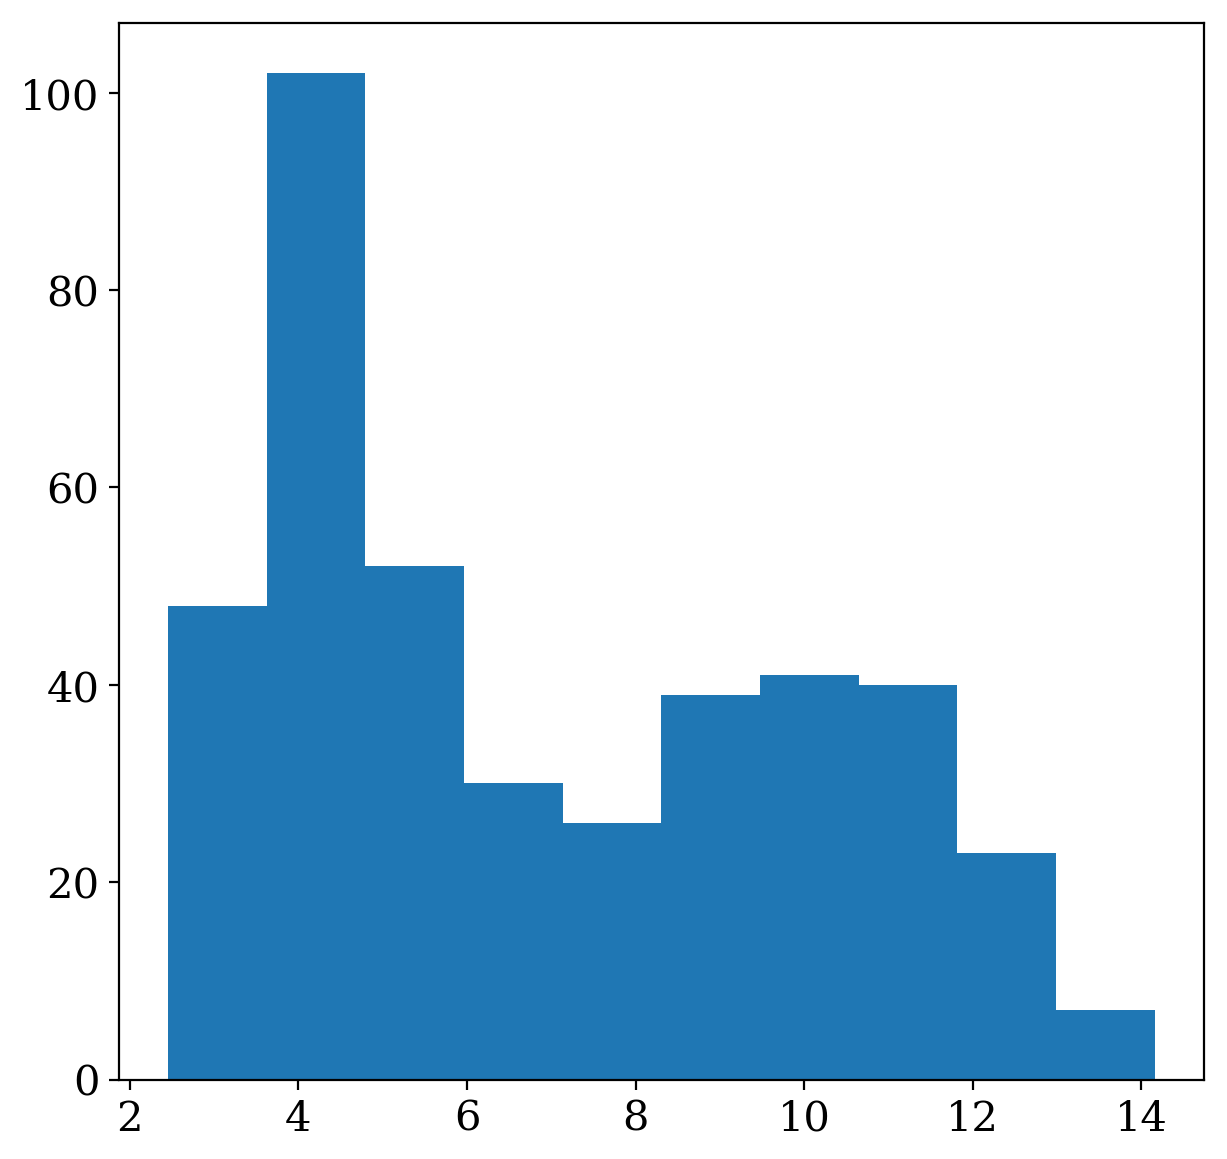

In [8175]:
v_drift =  velocity_scatter_3D(age, para[0], para[1], para[2], para[6])**2/80
v_drift_Q =  velocity_scatter_3D(age_Q, para[0], para[1], para[2], para[6])**2/80
vL, vB = np.array(get_v_delayed_3D(age, l, b, pml, pmb, factor, v_drift,U,V,W))
vL_Q, vB_Q = np.array(get_v_delayed_3D(age_Q, l_Q, b_Q, pml_Q, pmb_Q, factor_Q, v_drift_Q,\
                                       U,V,W))

plt.hist(v_drift)
#plt.hist(age,10)
plt.show()

In [ ]:
    
def plot_GOF_big(figsize=(15,8),xlim=(-150,150),ylim=[0.05,100],islog=True):
    plt.figure(figsize=figsize,dpi=200)
    
    early = np.array(1.22 - (age - 0.6) * 0.2> mass) #for ONe: 1.22; CO: 1.25
    late = np.array(1.22 - (age - 0.6) * 0.2 < mass) 
    
    xlabel = ['','$v_L$ [km/s]','$v_L$ [km/s]','$v_L$ [km/s]','$v_B$ [km/s]','$v_B$ [km/s]','$v_B$ [km/s]']
    label = ['','early','Q branch','late','early','Q branch','late']
    color = ['','lightseagreen','olivedrab','firebrick','lightseagreen','olivedrab','firebrick']
    curve_content = ['',early_v[:,0],Q_v[:,0],late_v[:,0],early_v[:,1],Q_v[:,1],late_v[:,1]]
    hist_content = ['',vL[early],vL_Q,vL[late],vB[early],vB_Q,vB[late]]
    for i in range(1,7):
        ax = plt.subplot(2,3,i)  
        plt.plot(v_test,curve_content[i]*len(hist_content[i])*number_factor/hist_bin,
                 label=label[i],color=color[i])
        hist, bins = np.histogram(hist_content[i],hist_bin,hist_range)
        plt.errorbar((bins[:-1]+bins[1:])/2, hist, hist**0.5, 0, '.',color=color[i],lw=1)
        #plt.legend(prop={'size': 12})
        if islog==True:
            plt.yscale('log')
        #plt.title(label[i],fontsize=15)
        plt.ylim(ylim[0],ylim[1])
        plt.xlim(xlim[0],xlim[1])
        plt.xlabel(xlabel[i],fontsize=20,family='serif')
        plt.xticks(fontsize=15, family='serif');
        plt.yticks([0,30,60,90],fontsize=15, family='serif')
        if i%3==1:
            plt.ylabel('count per bin',fontsize=20,family='serif')
        cdf = interp1d(v_test, np.cumsum(curve_content_0[i])*number_factor/n_v_bin,
                        bounds_error=False, fill_value=(0,1))
        s,p = kstest(hist_content[i], cdf, args=(), N=20, alternative='two-sided', mode='approx')
        plt.text(0.05, 0.95, 'p-value: %.3f\n(KS test)' % p, horizontalalignment='left',
                 verticalalignment='top', transform=ax.transAxes,fontsize=13, family='serif')
        plt.text(0.95, 0.95, label[i], horizontalalignment='right',
                 verticalalignment='top', transform=ax.transAxes,fontsize=17, color=color[i])
        plt.subplots_adjust(wspace =0.2, hspace =0.4)#调整子图间距
    plt.show()
    
def plot_GOF_combined(figsize=(15,4),xlim=(-150,150),ylim=[0.05,100],islog=True):
    plt.figure(figsize=figsize,dpi=200)
    
    early = np.array(1.22 - (age - 0.6) * 0.2> mass) #for ONe: 1.22; CO: 1.25
    late = np.array(1.22 - (age - 0.6) * 0.2 < mass) 
    
    xlabel = ['','$v_L$ [km/s]','$v_L$ [km/s]','$v_L$ [km/s]','$v_B$ [km/s]','$v_B$ [km/s]','$v_B$ [km/s]']
    label = ['','early','Q branch','late','early','Q branch','late']
    color = ['','lightseagreen','olivedrab','firebrick','lightseagreen','olivedrab','firebrick']
    curve_content = ['',early_v[:,0],Q_v[:,0],late_v[:,0],early_v[:,1],Q_v[:,1],late_v[:,1]]
    hist_content = ['',vL[early],vL_Q,vL[late],vB[early],vB_Q,vB[late]]
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)
    for i in range(1,7):
        if i%2==0:
            ax = ax2
        if i%2==1:
            ax = ax1
        ax.plot(v_test,curve_content[i]*len(hist_content[i])*number_factor/hist_bin,
                 label=label[i],color=color[i])
        hist, bins = np.histogram(hist_content[i],hist_bin,hist_range)
        ax.errorbar((bins[:-1]+bins[1:])/2, hist, hist**0.5, 0, '.',color=color[i],lw=1)
        #plt.legend(prop={'size': 12})
        if islog==True:
            ax.set_yscale('log')
        else:
            ax.set_yticks([0,40,80])
        #plt.title(label[i],fontsize=15)
        ax.set_ylim(ylim[0],ylim[1])
        ax.set_xlim(xlim[0],xlim[1])
        ax.set_xlabel(xlabel[i])
        #ax.set_xticks(fontsize=15, family='serif');
        ax.set_ylabel('count per bin',fontsize=20,family='serif')
        #cdf = interp1d(v_test, np.cumsum(curve_content[i])*number_factor/n_v_bin,
        #                bounds_error=False, fill_value=(0,1))
        #s,p = kstest(hist_content[i], cdf, args=(), N=20, alternative='two-sided', mode='approx')
        #plt.text(0.05, 0.95, 'p-value: %.3f\n(KS test)' % p, horizontalalignment='left',
        #         verticalalignment='top', transform=ax.transAxes,fontsize=13, family='serif')
        #plt.text(0.95, 0.95, label[i], horizontalalignment='right',
        #         verticalalignment='top', transform=ax.transAxes,fontsize=17, color=color[i])
        #plt.subplots_adjust(wspace =0.2, hspace =0.4)#调整子图间距
    plt.show()
    
def plot_GOF(figsize=(15,4),xlim=(-150,150),ylim=[0.05,100],islog=True):
    plt.figure(figsize=figsize,dpi=200)
    tick_size = 15
    label_size = 17
    title_size = 20
    
    early = np.array(1.22 - (age - 0.6) * 0.2> mass) #for ONe: 1.22; CO: 1.25
    late = np.array(1.22 - (age - 0.6) * 0.2 < mass) 
    
    xlabel = ['','$v_L$ [km/s]','$v_L$ [km/s]','$v_L$ [km/s]','$v_B$ [km/s]','$v_B$ [km/s]','$v_B$ [km/s]']
    label = ['','early','Q branch','late','early','Q branch','late']
    color = ['','lightseagreen','olivedrab','firebrick','lightseagreen','olivedrab','firebrick']
    curve_content = ['',early_v[:,0],Q_v[:,0],late_v[:,0],early_v[:,1],Q_v[:,1],late_v[:,1]]
    hist_content = ['',vL[early],vL_Q,vL[late],vB[early],vB_Q,vB[late]]
    for i in range(1,7):
        ax = plt.subplot(2,3,i)
        plt.plot(v_test,curve_content[i]*len(hist_content[i])*number_factor/hist_bin,
                 label=label[i],color=color[i])
        hist, bins = np.histogram(hist_content[i],hist_bin,hist_range)
        plt.errorbar((bins[:-1]+bins[1:])/2, hist, hist**0.5, 0, '.',color=color[i],lw=1)
        if islog==True:
            plt.yscale('log')
            plt.yticks(fontsize=tick_size, family='serif')
        else:
            plt.yticks([0,40,80],fontsize=tick_size, family='serif')
        plt.xticks(fontsize=tick_size, family='serif');
        
        plt.ylim(ylim[0],ylim[1])
        plt.xlim(xlim[0],xlim[1])
        if i==1:
            #plt.ylabel('count per bin',fontsize=label_size,family='serif',local)
            plt.text(-0.2,0,'count per bin',horizontalalignment='center',rotation=90,
                 verticalalignment='center', transform=ax.transAxes,fontsize=label_size, family='serif')
        if i<=3:
            plt.title(label[i], fontsize=title_size, color=color[i])
            plt.setp(ax.get_xticklabels(), visible=False)
            plt.text(0.95, 0.95, '$v_L$', horizontalalignment='right',
                 verticalalignment='top', transform=ax.transAxes,fontsize=20)
        if i>3:
            plt.xlabel('velocity [km/s]',fontsize=label_size,family='serif')
            plt.text(0.95, 0.95, '$v_B$', horizontalalignment='right',
                 verticalalignment='top', transform=ax.transAxes,fontsize=20)
            
            
        cdf = interp1d(v_test, np.cumsum(curve_content[i])*number_factor/n_v_bin,
                        bounds_error=False, fill_value=(0,1))
        s,p = kstest(hist_content[i], cdf, args=(), N=20, alternative='two-sided', mode='approx')
        plt.text(0.05, 0.95, 'p-value: %.3f\n(KS test)' % p, horizontalalignment='left',
                 verticalalignment='top', transform=ax.transAxes,fontsize=tick_size, family='serif')
        plt.subplots_adjust(wspace =0.2, hspace =0.0)#调整子图间距
    plt.show()

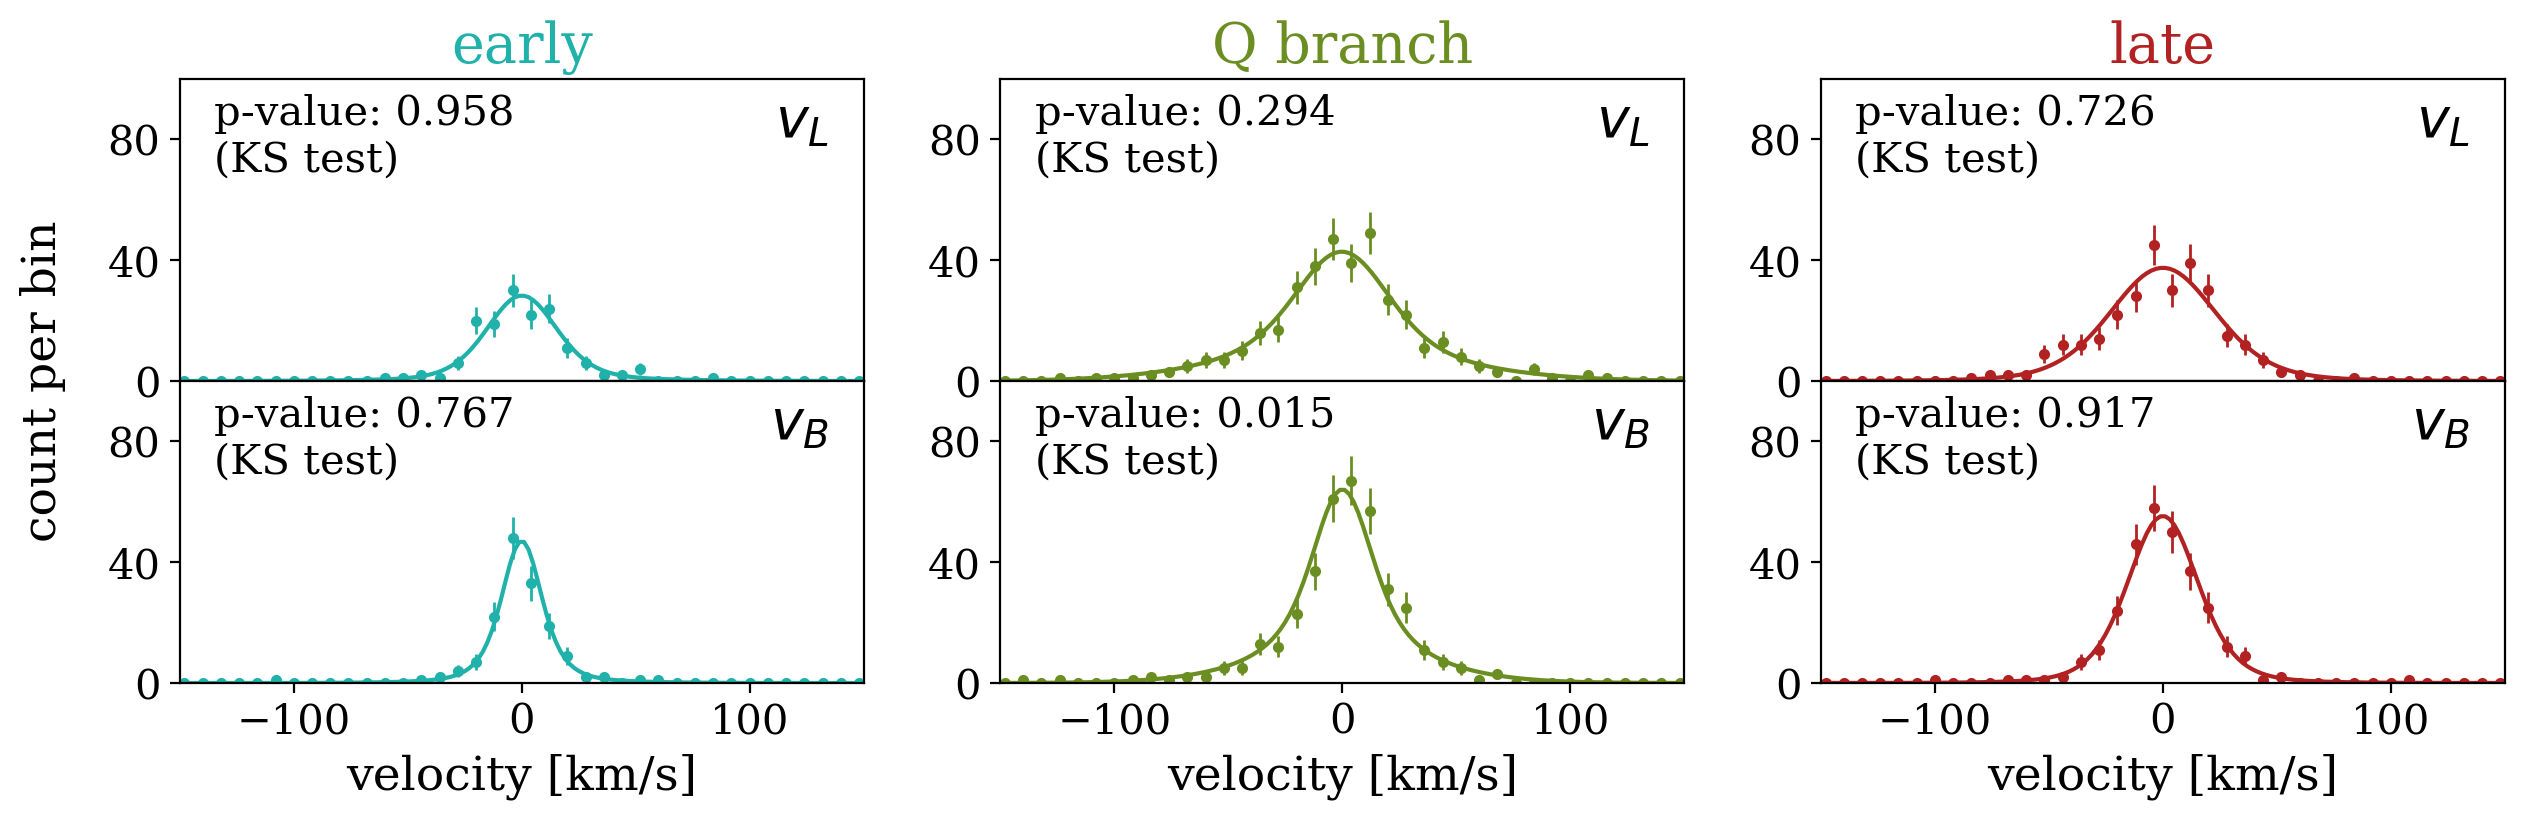

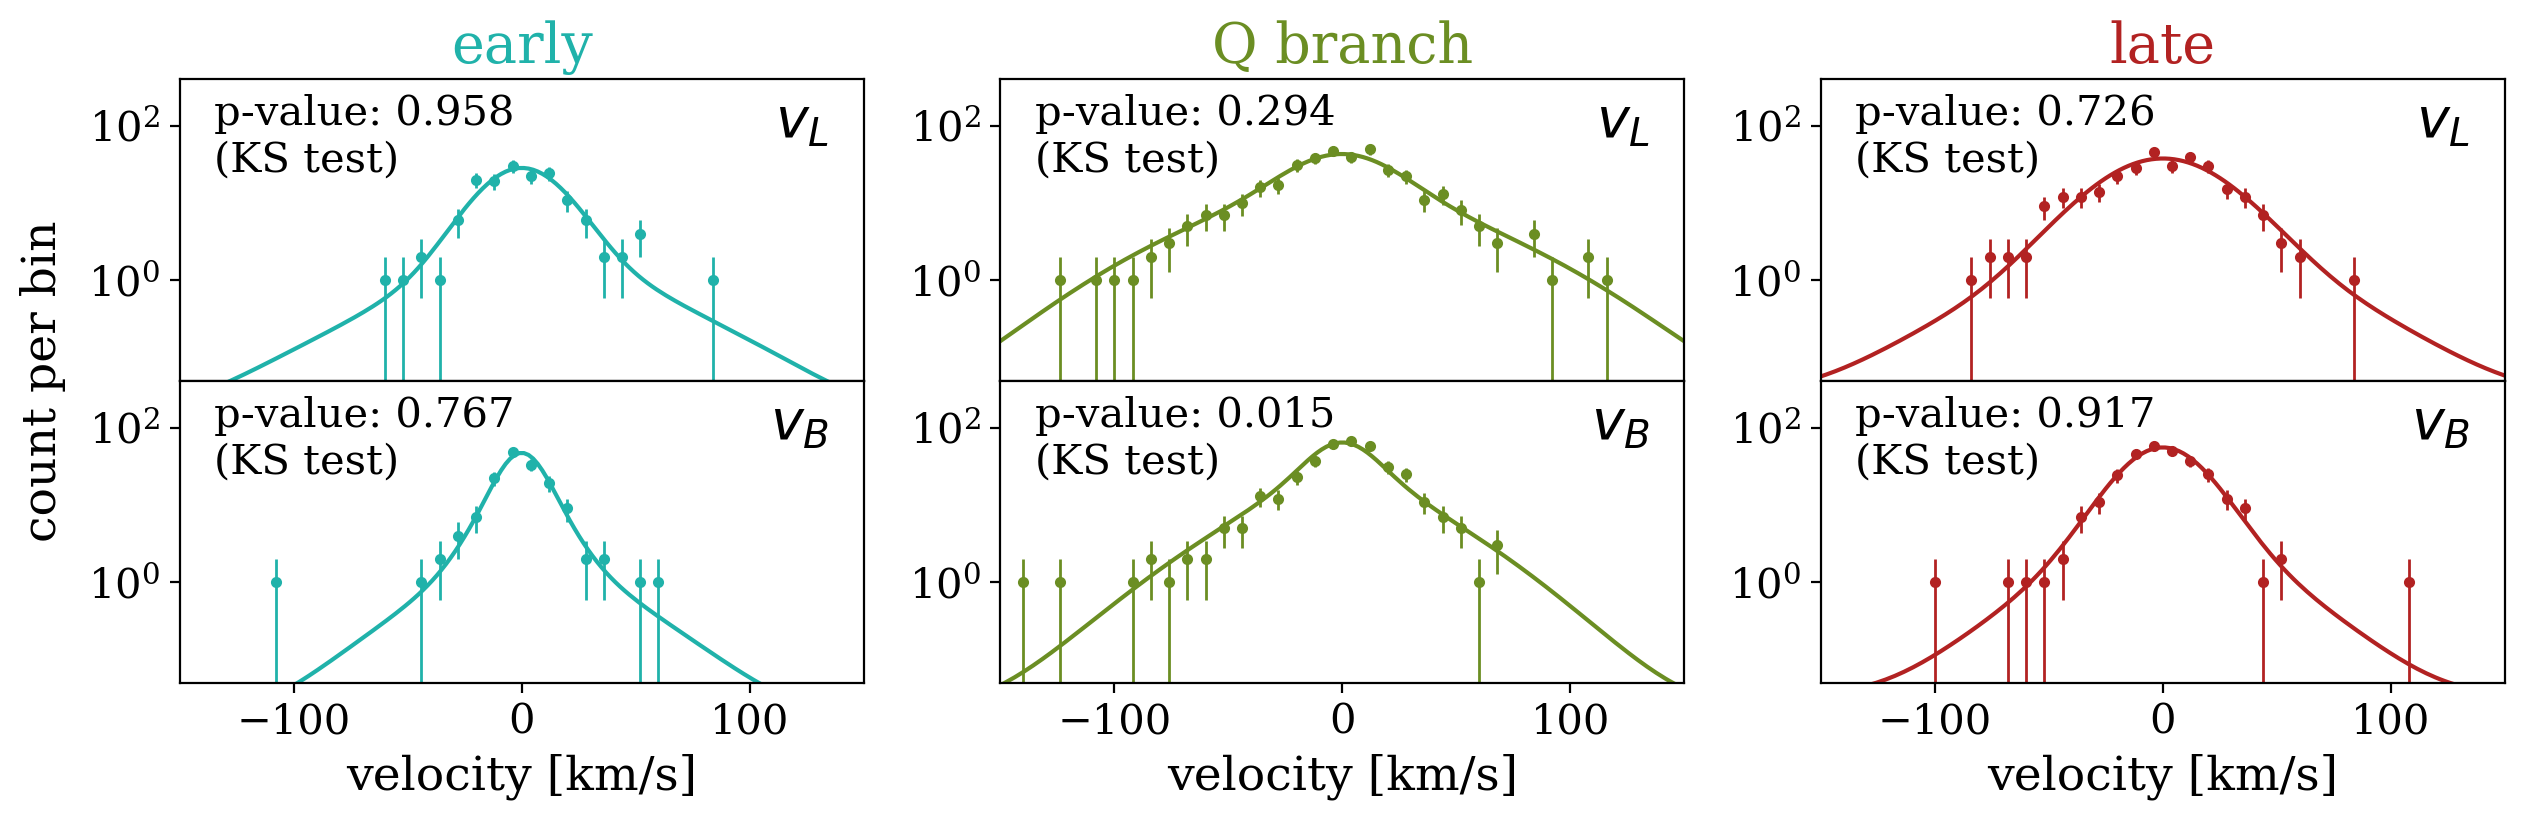

In [7644]:
# best fit
plot_GOF(islog=False,ylim=(0.05,1*5000/hist_bin))
plot_GOF(islog=True,ylim=(0.05,1*20000/hist_bin))

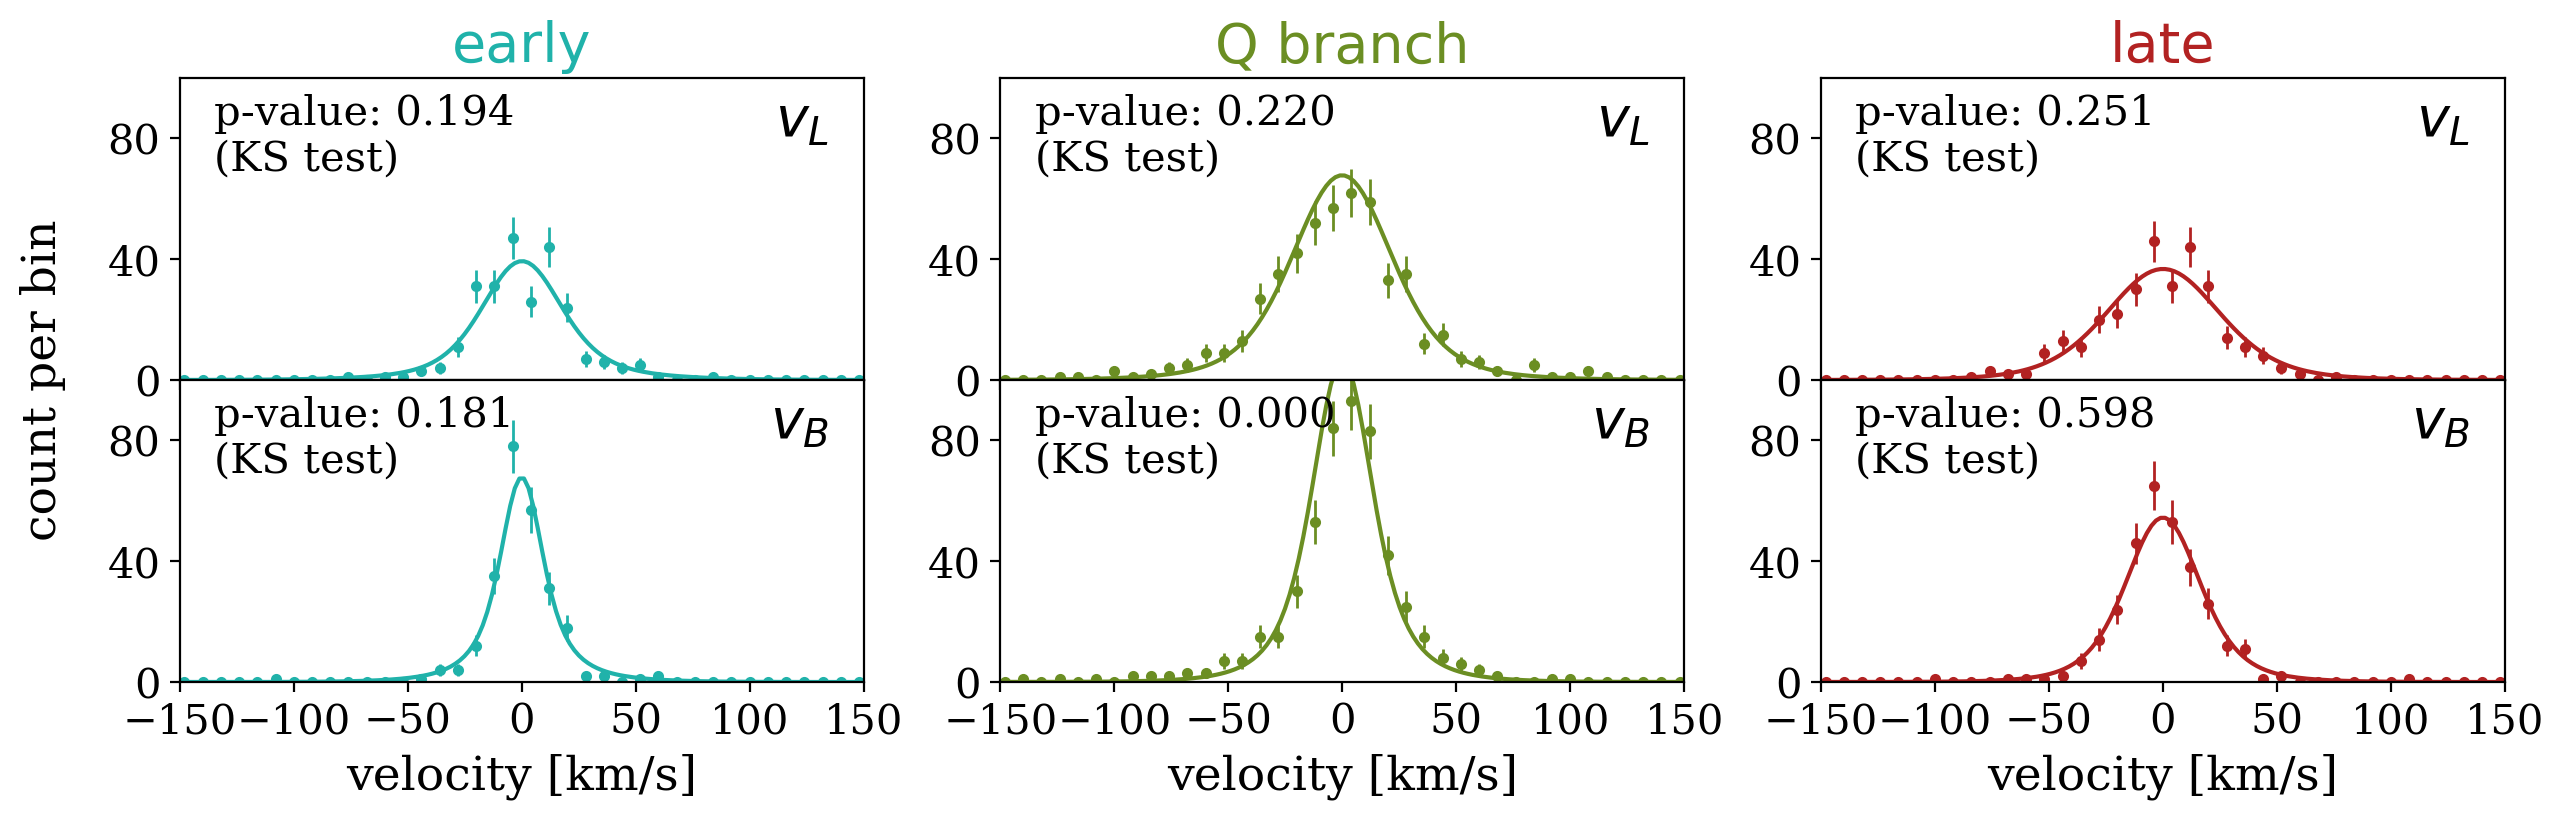

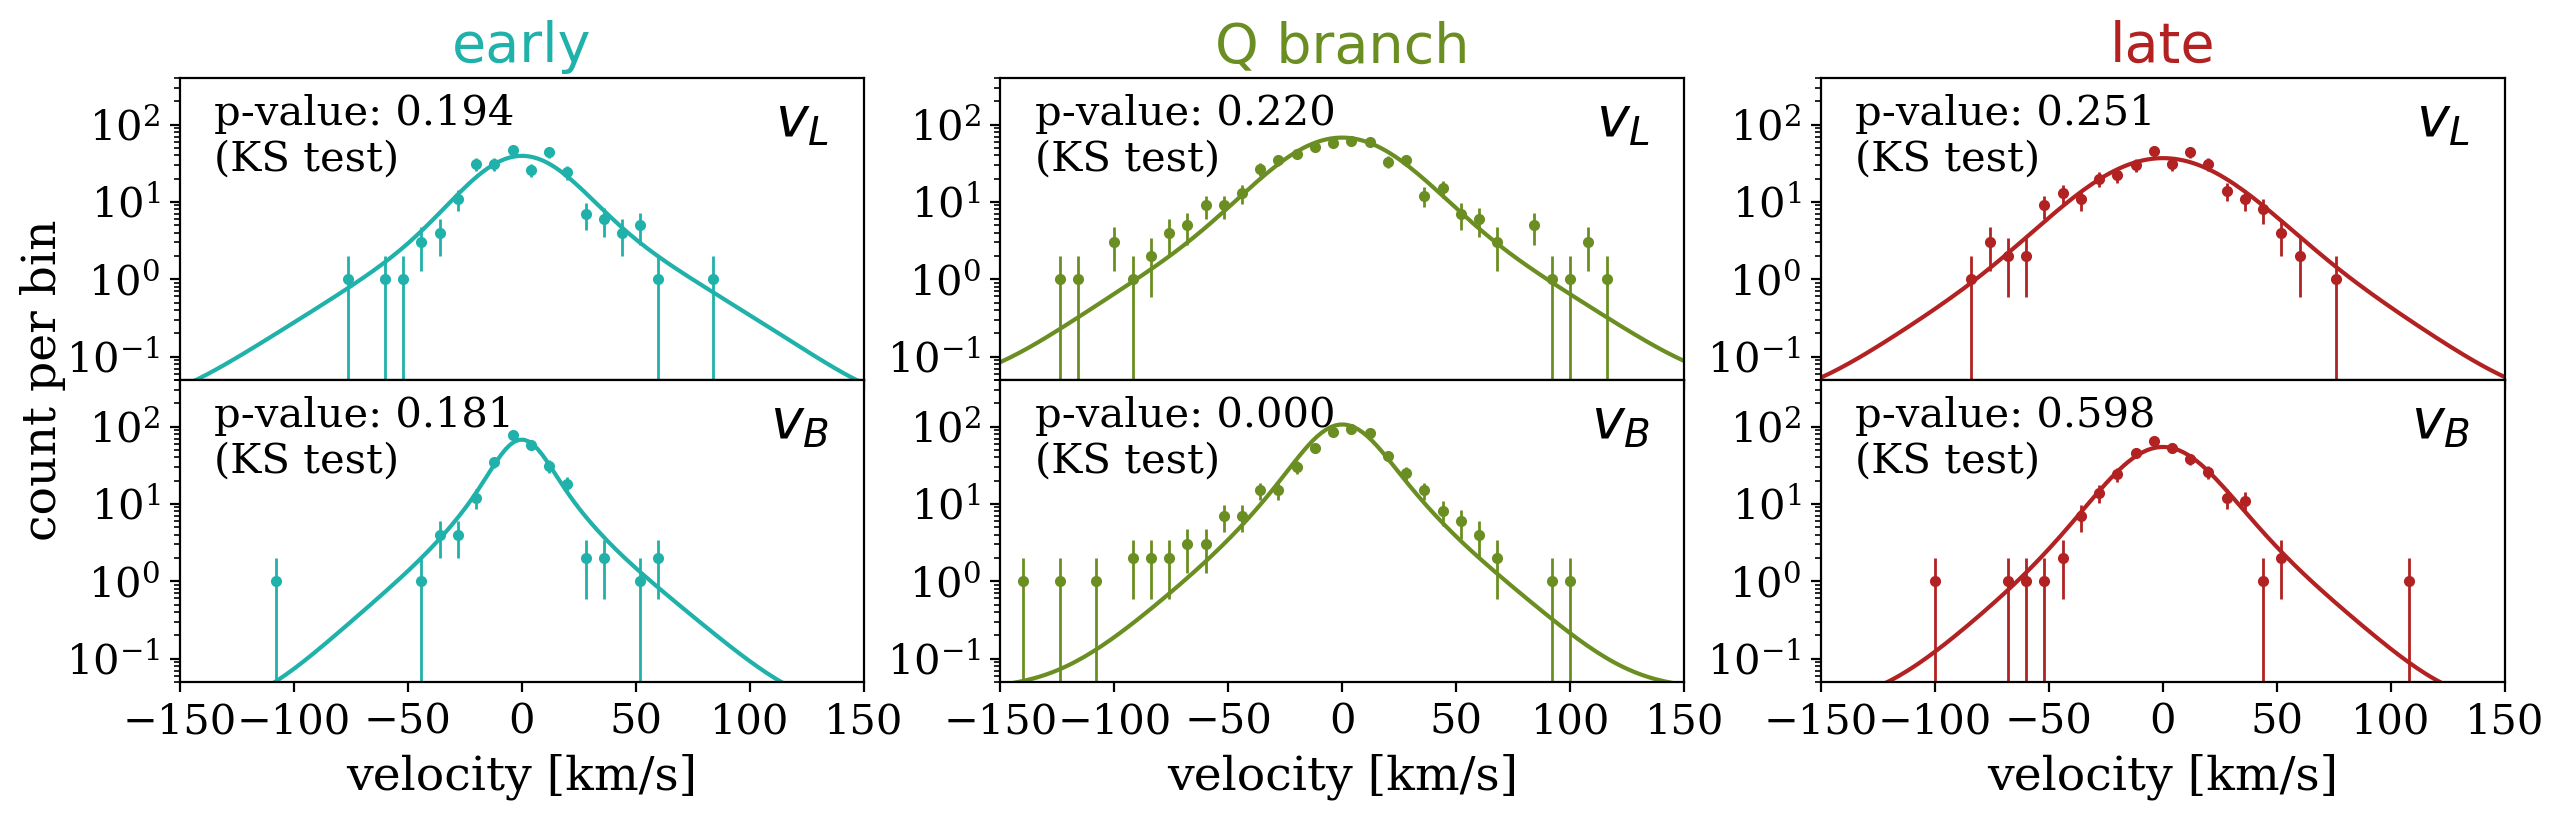

In [6538]:
# no Q population
plot_GOF(islog=False,ylim=(0.05,1*5000/hist_bin))
plot_GOF(islog=True,ylim=(0.05,1*20000/hist_bin))

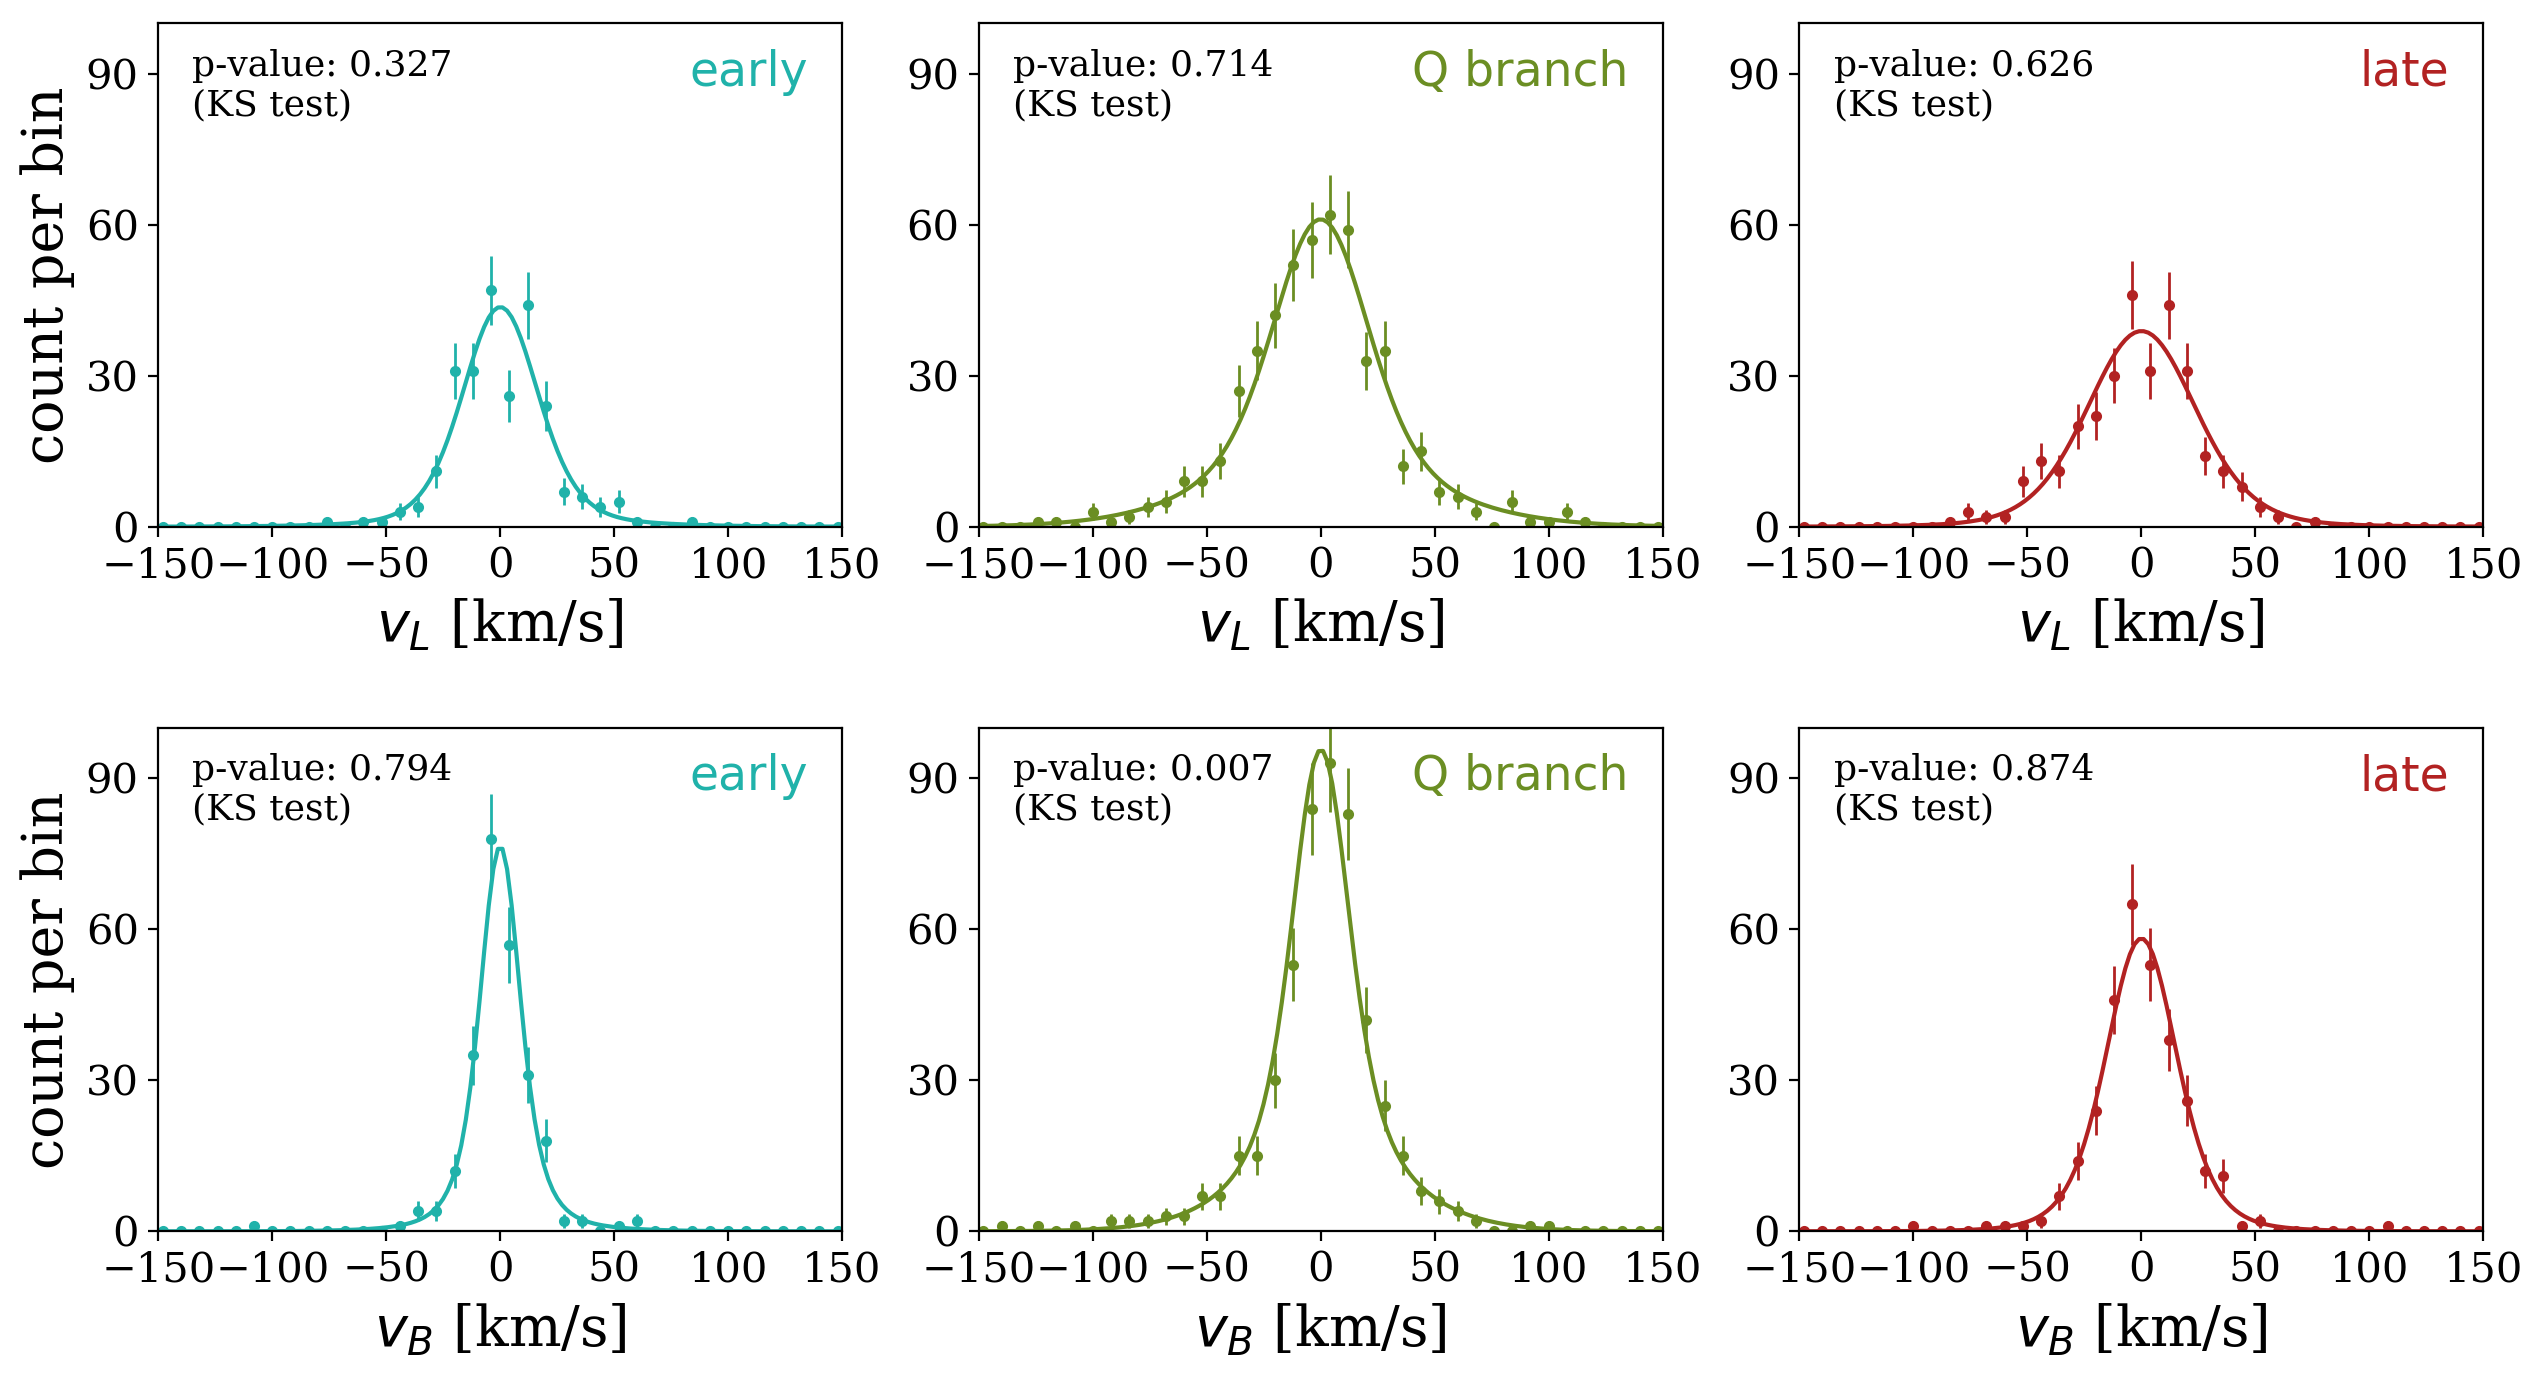

In [6409]:
plot_GOF_big(islog=False,ylim=(0.05,1*5000/hist_bin))

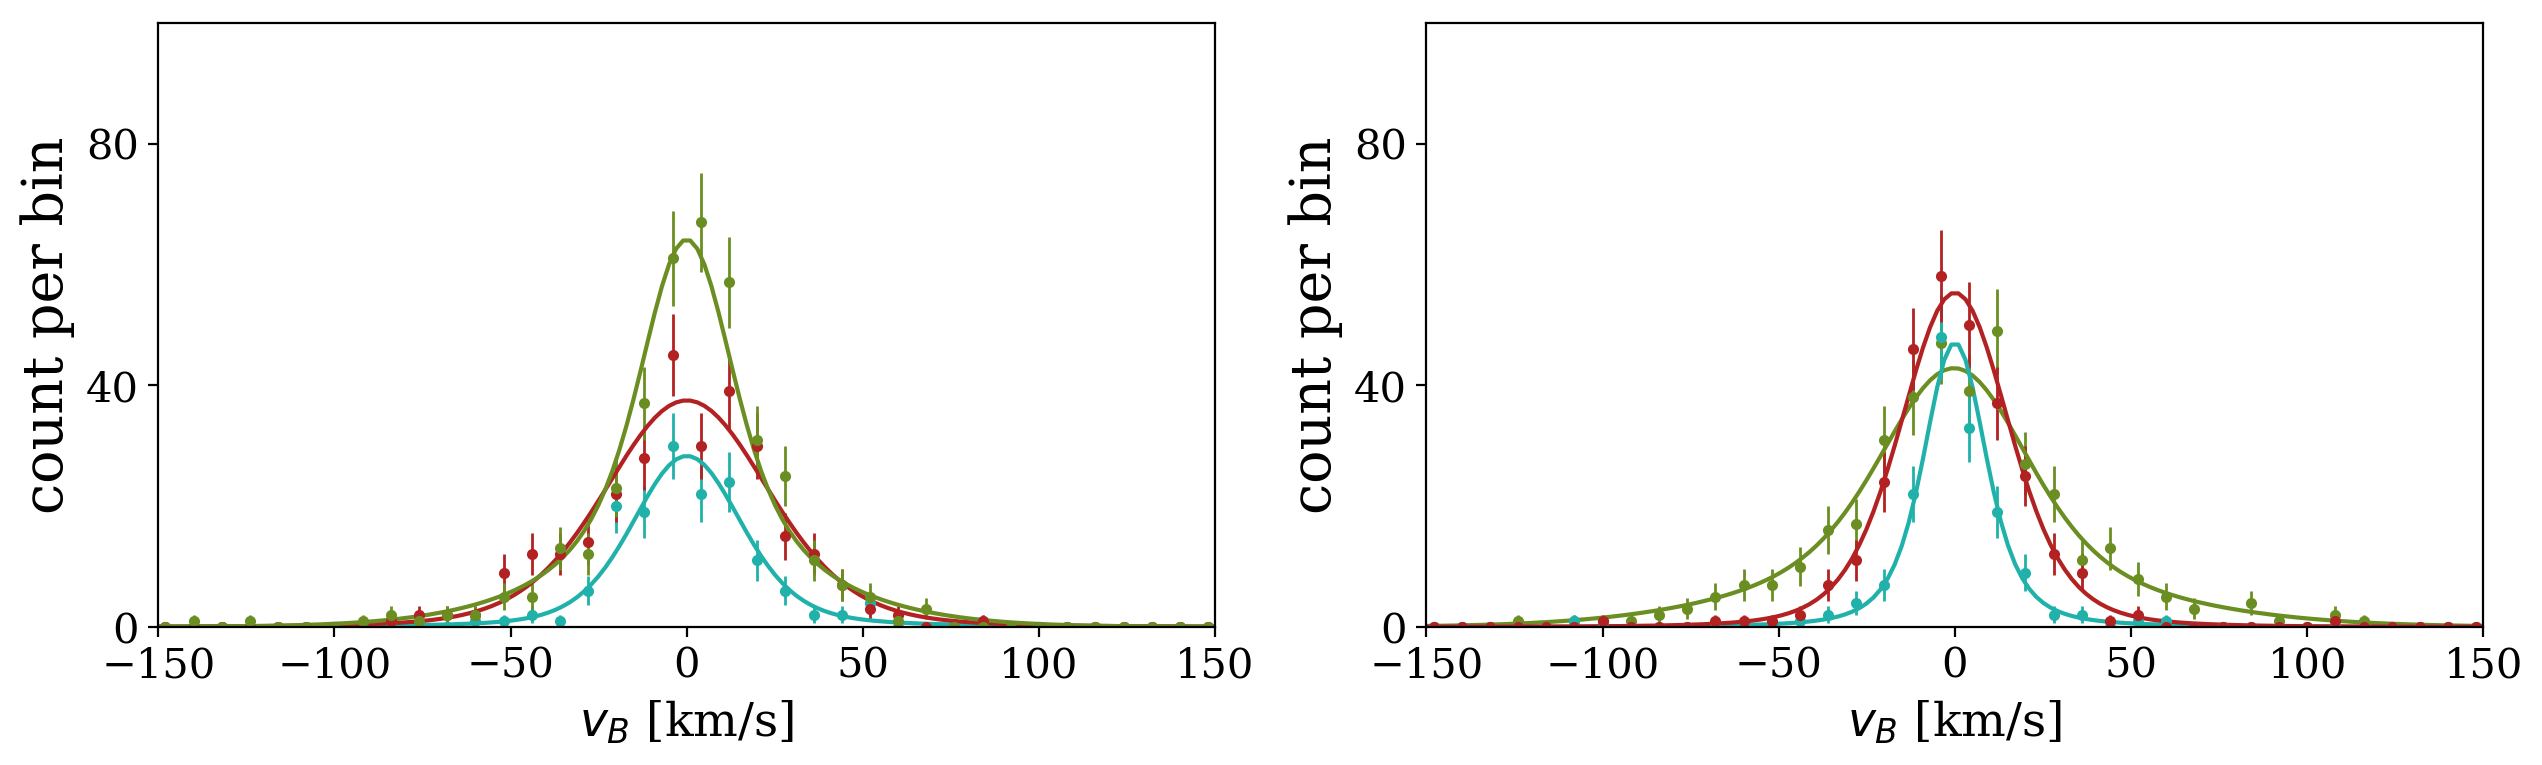

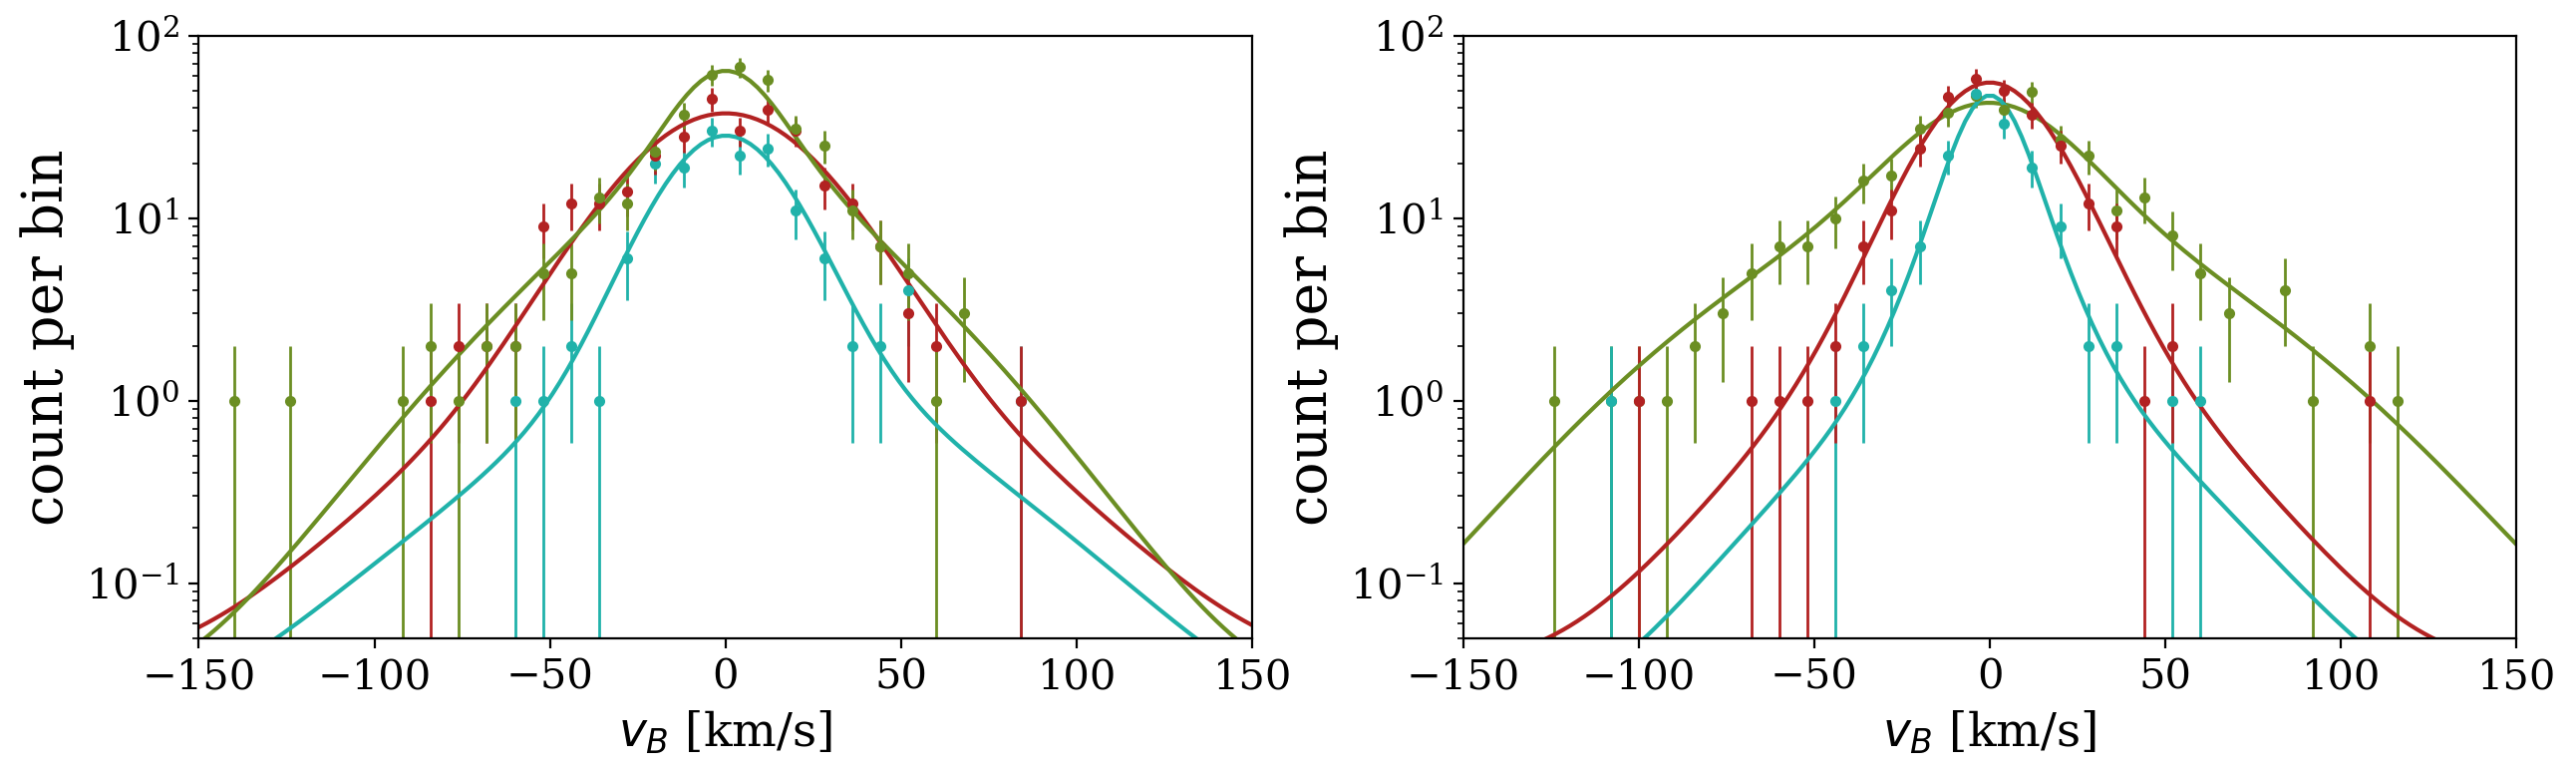

In [7643]:
plot_GOF_combined(islog=False,ylim=(0.05,1*5000/hist_bin))
plot_GOF_combined(islog=True,ylim=(0.05,1*5000/hist_bin))

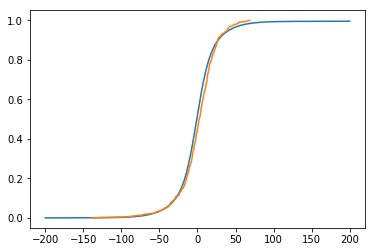

vL early KstestResult(statistic=0.04406406587073218, pvalue=0.9294258123114456)
vB early KstestResult(statistic=0.057959890177703755, pvalue=0.6934942832942008)
vL late KstestResult(statistic=0.04138572897599291, pvalue=0.7232158918795251)
vB late KstestResult(statistic=0.031226427124466327, pvalue=0.9407328019760743)
vL Q KstestResult(statistic=0.04918384263595238, pvalue=0.3184904733063889)
vB Q KstestResult(statistic=0.08780069143567193, pvalue=0.005959027996664368)


In [6169]:
#SFR2 delay=8
early_vL_cdf = interp1d(v_test, np.cumsum(early_v,axis=0)[:,0]*number_factor/n_v_bin,
                        bounds_error=False, fill_value=(0,1))
early_vB_cdf = interp1d(v_test, np.cumsum(early_v,axis=0)[:,1]*number_factor/n_v_bin, 
                        bounds_error=False, fill_value=(0,1))
late_vL_cdf = interp1d(v_test, np.cumsum(late_v,axis=0)[:,0]*number_factor/n_v_bin, 
                       bounds_error=False, fill_value=(0,1))
late_vB_cdf = interp1d(v_test, np.cumsum(late_v,axis=0)[:,1]*number_factor/n_v_bin, 
                       bounds_error=False, fill_value=(0,1))
Q_vL_cdf = interp1d(v_test, np.cumsum(Q_v,axis=0)[:,0]*number_factor/n_v_bin, 
                    bounds_error=False, fill_value=(0,1))
Q_vB_cdf = interp1d(v_test, np.cumsum(Q_v,axis=0)[:,1]*number_factor/n_v_bin, 
                    bounds_error=False, fill_value=(0,1))

plt.plot(v_test, Q_vB_cdf(v_test))
plt.plot(np.sort(vB_Q),np.linspace(0,1,len(vB_Q)))
plt.show()
from scipy.stats import kstest
print('vL early',kstest(vL[early], early_vL_cdf, args=(), N=20, alternative='two-sided', mode='approx'))
print('vB early',kstest(vB[early], early_vB_cdf, args=(), N=20, alternative='two-sided', mode='approx'))
print('vL late',kstest(vL[late], late_vL_cdf, args=(), N=20, alternative='two-sided', mode='approx'))
print('vB late',kstest(vB[late], late_vB_cdf, args=(), N=20, alternative='two-sided', mode='approx'))
print('vL Q',kstest(vL_Q, Q_vL_cdf, args=(), N=20, alternative='two-sided', mode='approx'))
print('vB Q',kstest(vB_Q, Q_vB_cdf, args=(), N=20, alternative='two-sided', mode='approx'))

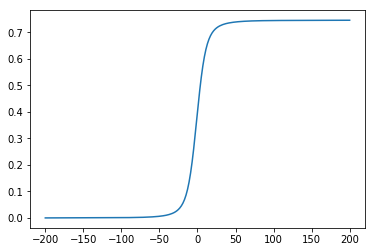

vL early KstestResult(statistic=0.261332034978875, pvalue=1.1990279880080834e-09)
vB early KstestResult(statistic=0.25859375483408265, pvalue=1.876340194328918e-09)
vL late KstestResult(statistic=0.2641295443034497, pvalue=0.0)
vB late KstestResult(statistic=0.2591977075125307, pvalue=0.0)
vL Q KstestResult(statistic=0.2539191540516714, pvalue=0.0)
vB Q KstestResult(statistic=0.2621793752268664, pvalue=0.0)


In [6136]:
# SFR2, Q_fraction = 0
early_vL_cdf = interp1d(v_test, np.cumsum(early_v,axis=0)[:,0]*1.5, bounds_error=False, fill_value=(0,1))
early_vB_cdf = interp1d(v_test, np.cumsum(early_v,axis=0)[:,1]*1.5, bounds_error=False, fill_value=(0,1))
late_vL_cdf = interp1d(v_test, np.cumsum(late_v,axis=0)[:,0]*1.5, bounds_error=False, fill_value=(0,1))
late_vB_cdf = interp1d(v_test, np.cumsum(late_v,axis=0)[:,1]*1.5, bounds_error=False, fill_value=(0,1))
Q_vL_cdf = interp1d(v_test, np.cumsum(Q_v,axis=0)[:,0]*1.5, bounds_error=False, fill_value=(0,1))
Q_vB_cdf = interp1d(v_test, np.cumsum(Q_v,axis=0)[:,1]*1.5, bounds_error=False, fill_value=(0,1))

plt.plot(v_test, early_vB_cdf(v_test))
plt.show()
from scipy.stats import kstest
print('vL early',kstest(vL[early], early_vL_cdf, args=(), N=20, alternative='two-sided', mode='approx'))
print('vB early',kstest(vB[early], early_vB_cdf, args=(), N=20, alternative='two-sided', mode='approx'))
print('vL late',kstest(vL[late], late_vL_cdf, args=(), N=20, alternative='two-sided', mode='approx'))
print('vB late',kstest(vB[late], late_vB_cdf, args=(), N=20, alternative='two-sided', mode='approx'))
print('vL Q',kstest(vL_Q, Q_vL_cdf, args=(), N=20, alternative='two-sided', mode='approx'))
print('vB Q',kstest(vB_Q, Q_vB_cdf, args=(), N=20, alternative='two-sided', mode='approx'))

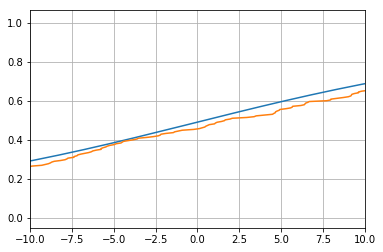

In [1793]:
plt.plot(v_test, Q_vB_cdf(v_test))
plt.plot(np.sort(vB_Q),np.linspace(0,1,len(vB_Q)))
plt.xlim(-10,10)
plt.grid()
plt.show()

## Define MCMC functions

In [9150]:
import WD_MCMC_func
importlib.reload(WD_MCMC_func)

META_PARA = ['',250,'1','Run_MCMC',False,False,False,True,-0.7,0.5]


METHOD = META_PARA[3]
WD_MCMC_func.t_gap_eff = 0.743

NOT_FIT_UVW = META_PARA[4]
NOT_FIT_INDEX = META_PARA[5]
FIXV = META_PARA[6]

WD_MCMC_func.Q_IS_MERGER= META_PARA[7]
WD_MCMC_func.DELAY_INDEX = -META_PARA[8]
WD_MCMC_func.DELAY_CUT = META_PARA[9]
    
##--------------------------------------------------------------------------------------------------
agents = 1
chunksize = 1
number = agents

from WD_MCMC_func import Nv, NQ, end_of_SF, age_T, DELAY_INDEX, DELAY_CUT, Q_IS_MERGER
burning = 1
then_run = 1
gap = 1
ndim, nwalkers = Nv+NQ, 44


# Load WD table
##--------------------------------------------------------------------------------------------------------------
SELECTION_PARA = [1.4,0.10,2,22,8,300]
WD_warwick_smaller = np.load('/datascope/menard/group/scheng/Gaia/WD_warwick_smaller.npy')[0]\
                                ['WD_warwick_smaller']
_, WD_warwick_smaller = WD_MCMC_func.select_WD(WD_warwick_smaller,SELECTION_PARA[0],SELECTION_PARA[1],
                                               SELECTION_PARA[2],
                                               SELECTION_PARA[3],SELECTION_PARA[4],SELECTION_PARA[5])

if WD_MCMC_func.Q_IS_MERGER==False:
    WD_MCMC_func.n = 400
    WD_MCMC_func.n_tc = 8000

# Select the WDs Suitable for MCMC
##-------------------------------------------------------------------------------------------------------------
mass_min = 1.075#1.1
mass_max = 1.22#1.27
distance1 = 0
distance2 = META_PARA[1]
spec_type = 'DA_thick'
model = 'ONe'
WD_model = eval('WD_models.'+spec_type+'_'+model)
age_lim = 3.5
WD_warwick_smaller['mass'] = WD_warwick_smaller['mass_'+spec_type+'_'+model]
WD_warwick_smaller['age'] = WD_warwick_smaller['age_'+spec_type+'_'+model]
Q_branch = np.array((WD_warwick_smaller['mass']>mass_min)*(WD_warwick_smaller['mass']<mass_max)*\
         (1/WD_warwick_smaller['parallax']*1000>distance1)*(1/WD_warwick_smaller['parallax']*1000<distance2)*\
        (WD_HR.func_select(WD_warwick_smaller['bp_rp'],WD_warwick_smaller['G'],13.20,1.2,0.20,-0.40,0.10)) )
WD = WD_warwick_smaller[np.array((WD_warwick_smaller['mass']>mass_min)*(WD_warwick_smaller['mass']<mass_max)*\
        (1/WD_warwick_smaller['parallax']*1000>distance1)*(1/WD_warwick_smaller['parallax']*1000<distance2)\
         * ~Q_branch )]
WD_Q = WD_warwick_smaller[Q_branch]

print('length of WD: ',len(WD), 'length of WD_Q: ',len(WD_Q))


# prepare to get v
pml,pmb,factor = WD_MCMC_func.prep_get_v(WD)
pml_Q, pmb_Q, factor_Q = WD_MCMC_func.prep_get_v(WD_Q)
v_drift = (((WD['age']+0.1)/10.1)**0.2*40)**2/80
v_drift_Q = (((WD_Q['age']+0.1)/10.1)**0.2*40)**2/80
vL, vB = np.array(WD_MCMC_func.get_v_delayed_3D(WD['age'], WD['l'], WD['b'], pml, pmb, factor, v_drift,
                                                10,7.5,6.5))
vL_Q, vB_Q = np.array(WD_MCMC_func.get_v_delayed_3D(WD_Q['age'], WD_Q['l'], WD_Q['b'], pml_Q, pmb_Q, factor_Q, 
                                                    v_drift_Q,10,7.5,6.5))

selection = np.array(((WD['age'])<age_lim)*((WD['age'])>0.1)*(np.abs(vL<200))*(np.abs(vB<200)))
mass = np.array(WD['mass'][selection])
age = np.array(WD['age'][selection])
l = np.array(WD['l'][selection])
b = np.array(WD['b'][selection])
vL = vL[selection]
vB = vB[selection]
pml = pml[selection]
pmb = pmb[selection]
factor = factor[selection]

selection_Q = np.array(((WD_Q['age'])<age_lim)*((WD_Q['age'])>0.1)*(np.abs(vL_Q<200))*(np.abs(vB_Q<200)))
mass_Q = np.array(WD_Q['mass'][selection_Q])
age_Q = np.array(WD_Q['age'][selection_Q])
l_Q = np.array(WD_Q['l'][selection_Q])
b_Q = np.array(WD_Q['b'][selection_Q])
vL_Q = vL_Q[selection_Q]
vB_Q = vB_Q[selection_Q]
pml_Q = pml_Q[selection_Q]
pmb_Q = pmb_Q[selection_Q]
factor_Q = factor_Q[selection_Q]

##--------------------------------------------------------------------------------------------------
def parallel(i):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, WD_MCMC_func.ln_prob, 
                                    args=[mass, age, pml, pmb, factor, l, b,
                                          mass_Q, age_Q, pml_Q, pmb_Q, factor_Q, l_Q, b_Q,
                                          NOT_FIT_UVW, NOT_FIT_INDEX, FIXV])
    a_random_number = np.random.randint(0,100000)
    np.random.seed(i+a_random_number)
    # "power index", "v10", "v_T",
    #"index_z","v10_z",
    #"sy/sx",
    #"v0","v0_z","v_T_z",
    #"sy/sx_T"
    #UVW
    #"fraction", "delay", "background"
    #
    p0 = [np.concatenate((\
            np.random.rand(1)*0.1*2+0.3-0.1, np.random.rand(1)*10*2+30-10, np.random.rand(1)*10*2+50-10,
            np.random.rand(1)*0.15*2+0.5-0.15, np.random.rand(1)*10*2+15-10,
            np.random.rand(1)*0.1*2+0.67-0.1,
            np.random.rand(1)*4*2+5-4, np.random.rand(1)*4*2+5-4, np.random.rand(1)*10*2+40-10,
            np.random.rand(1)*0.1*2+0.63-0.1,
            np.array([5,5,5])+np.random.rand(3)*np.array([5,5,5]),
            np.array([0.1,0,0])+np.random.rand(3)*np.array([0.2,12,0.01]),
            np.array([5,5,0.05,5])+np.random.rand(4)*np.array([5,5,0.2,5]) )) for j in range(nwalkers)] #SFR2
    pos, _, _ = sampler.run_mcmc(p0, burning)
    sampler.reset()
    sampler.run_mcmc(pos, then_run)
    a = sampler.flatchain[::gap,:]
    return a

71597
length of WD:  528 length of WD_Q:  465


/home/scheng/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/home/scheng/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


## Run MCMC One Time

In [9104]:
burning = 1
then_run = 1
gap = 1

# Run MCMC
##--------------------------------------------------------------------------------------------------
if METHOD == 'Run_MCMC':
    with Pool(processes=agents) as pool:
        result = pool.map(parallel, np.arange(number), chunksize)  
    sampling_per_agent = nwalkers*(then_run//gap)
    
    para_v = np.empty((number*sampling_per_agent,Nv))
    para_Q = np.empty((number*sampling_per_agent,NQ))
    for i in range(number):
        para_v[(i*sampling_per_agent):((i+1)*sampling_per_agent)] = result[i][:,:Nv]
        para_Q[(i*sampling_per_agent):((i+1)*sampling_per_agent)] = result[i][:,Nv:Nv+NQ]
    para_v = para_v.reshape(agents,nwalkers,then_run//gap,Nv).transpose((2,1,0,3))\
                                            .reshape(number*nwalkers*(then_run//gap),Nv)
    para_Q = para_Q.reshape(agents,nwalkers,then_run//gap,NQ).transpose((2,1,0,3))\
                                            .reshape(number*nwalkers*(then_run//gap),NQ)
    #-------------------------------------------------------------------------------------------------------
    para_input = np.median(np.concatenate((para_v,para_Q),axis=1)[:,:],axis=0)

IndexError: index 3 is out of bounds for axis 0 with size 3

In [9132]:
x_list = ['np.arange(0,15,0.2)','np.arange(0,0.45,0.01)','np.arange(0,0.45,0.01)']
PDF_test_name = ['delay_test','mfraction','Qfraction']
changed_para = [Nv+1, Nv+5 , Nv+0]
for PDF_test_index in range(3):
    pdf_sim = np.empty_like(eval(x_list[PDF_test_index]))
    pdf_Q_sim = np.empty_like(eval(x_list[PDF_test_index]))
    pdf_e_sim = np.empty_like(eval(x_list[PDF_test_index]))
    pdf_l_sim = np.empty_like(eval(x_list[PDF_test_index]))

    for i,x in enumerate(eval(x_list[PDF_test_index])):
        para = para_input.copy()
        para[changed_para[PDF_test_index]] = x
        pdf_sim[i], temp1, temp2, temp = WD_MCMC_func.ln_likelihood_pheno(para, mass, age, pml, pmb, factor,
                                       l, b, mass_Q, age_Q, pml_Q, pmb_Q, factor_Q, l_Q, b_Q,
                                               False,
                                               not_fit_UVW=NOT_FIT_UVW,not_fit_index=NOT_FIT_INDEX,fixv=FIXV)
        pdf_e_sim[i] = temp1[~np.isnan(temp1)].sum()
        pdf_l_sim[i] = temp2[~np.isnan(temp2)].sum()
        pdf_Q_sim[i] = temp[~np.isnan(temp)].sum()
    exec( PDF_test_name[PDF_test_index]+'= [pdf_sim,pdf_e_sim,pdf_l_sim,pdf_Q_sim ]')

#------------------------------------------------------------------------------------------------------------
if Q_IS_MERGER == True:
    suffix = '.npy'
if Q_IS_MERGER == False:
    suffix = 'Qisnotmerger.npy'

final_result = np.array([{'para_Q':para_Q, 'para_v':para_v,
                   'delay_test':delay_test, 'mfraction':mfraction, 'Qfraction':Qfraction,
                   'data_length':[selection.sum(),selection_Q.sum()],
                 'para_input':para_input,
                  'selection_para':SELECTION_PARA,
                  'delay_index_cut':[DELAY_INDEX, DELAY_CUT]}])
print('all finished')

all finished


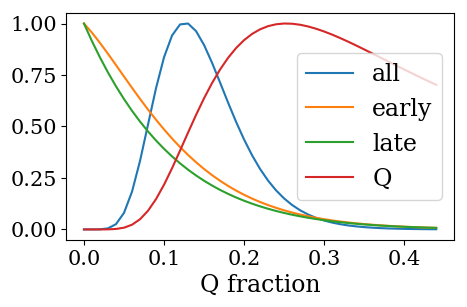

In [9147]:
plt.figure(figsize=(5,3),dpi=100)
label = ['all','early','late','Q']
for i in range(0,4):
    plt.plot(np.arange(0,0.45,0.01),np.exp(final_result[0]['Qfraction'][i]-final_result[0]['Qfraction'][i].max()),
             label=label[i])
plt.legend()
plt.xlabel('Q fraction')
plt.show()

## test the normalization

In [9151]:
para = np.array([0.3, 30, 50,
                 0.5, 15,
                 0.45,
                 5 ,2 ,40 ,0.45,
                 9,7,6,
                 0.15, 9 ,0.004 , -6, 0.5, 0.15])

In [9154]:
%%timeit -n 1 -r 1

temp_sum = 0
late_sum = 0
Q_sum = 0
for vel in np.arange(-199.75,200,0.5):
    if True:
        pml_test, pmb_test, pml_Q_test, pmb_Q_test = pm_test(para, 
           mass[1:2], age[1:2], np.array([0]), np.array([vel]), pml[1:2], pmb[1:2], 
                factor[1:2], l[1:2], b[1:2], selection[1:2],\
           mass_Q[1:2], age_Q[1:2], np.array([0]), np.array([vel]), pml_Q[1:2], pmb_Q[1:2], 
                factor_Q[1:2], l_Q[1:2], b_Q[1:2], selection_Q[1:2])
        temp,early_vB,late_vB,Q_vB = WD_MCMC_func.ln_likelihood_pheno(para,\
                        mass[1:2], age[1:2], np.array([0]), pmb_test, factor[1:2], l[1:2], b[1:2],\
                        mass_Q[1:2], age_Q[1:2], np.array([0]), pmb_Q_test, factor_Q[1:2], l_Q[1:2], b_Q[1:2],\
                        True, WD_MCMC_func.velocity_density_3D_check, False)
        Q_sum+=np.exp(Q_vB)
        late_sum+=np.exp(late_vB)
        temp_sum+=np.exp(temp)
    else:
        pml_test, pmb_test, pml_Q_test, pmb_Q_test = pm_test(para, 
           mass[1:2], age[1:2], np.array([vel]), np.array([0]),pml[1:2], pmb[1:2], 
                factor[1:2], l[1:2], b[1:2], selection[1:2],\
           mass_Q[1:2], age_Q[1:2], np.array([vel]), np.array([0]), pml_Q[1:2], pmb_Q[1:2], 
                factor_Q[1:2], l_Q[1:2], b_Q[1:2], selection_Q[1:2])
        temp,early_vL,late_vL,Q_vL = WD_MCMC_func.ln_likelihood_pheno(para,\
                        mass[1:2], age[1:2], pml_test, np.array([0]), factor[1:2], l[1:2], b[1:2],\
                        mass_Q[1:2], age_Q[1:2], pml_Q_test, np.array([0]), factor_Q[1:2], l_Q[1:2], b_Q[1:2],\
                        True, WD_MCMC_func.velocity_density_3D_check, True)
        
        Q_sum+=np.exp(Q_vL)
        late_sum+=np.exp(late_vL)
        temp_sum+=np.exp(temp)
print(temp_sum, late_sum, Q_sum, (Q_sum)**500,selection.sum(),selection_Q.sum())

0.01529277072206587 [0.99999993] [1.00040603] [1.22503744] 473 465
1min 3s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
0.01529277072206587 [0.99999993] [1.00040603] [1.22503744] 473 465
1min 3s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

In [6836]:
def check_temp(l,b):
    A = np.array([[-np.sin(l/180*np.pi), -np.sin(b/180*np.pi)*np.cos(l/180*np.pi), \
                   np.cos(b/180*np.pi)*np.cos(l/180*np.pi)],\
                  [np.cos(l/180*np.pi), -np.sin(b/180*np.pi)*np.sin(l/180*np.pi), \
                   np.cos(b/180*np.pi)*np.sin(l/180*np.pi)],\
                  [0, np.cos(b/180*np.pi), np.sin(b/180*np.pi)]])
    return np.linalg.det(A)
check_temp(-20,40)

0.9999999999999999